In [215]:
import matplotlib.pyplot as plt
import pandas as pd
import pygraphviz as pgv
import networkx as nx
import numpy as np
from collections import defaultdict
import seaborn as sns
import scipy
from scipy.special import gammaln, logsumexp

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [216]:
def build_matrix(G, ncells, nmutations):
    mat = np.zeros((ncells, nmutations))
    node_map = defaultdict()
    root = None
    for n in G.nodes():
        if G.in_degree(n) == 0:
            node_map[n] = np.array([0,0,0,0,0])
        elif G.out_degree(n) > 0:
            node_map[n] = np.array([0,0,0,0,0])
            for pred in list(nx.ancestors(G, n)):
                if int(pred) <= nmutations:
                    node_map[n][int(pred) - 1] = 1
            node_map[n][int(n) - 1] = 1
        

    for n in G.nodes():
        # Get all outgoing edges from the node
        out_edges = G.out_edges(n)
        # Extract the target nodes from the edges
        outdegree_nodes = [target for _, target in out_edges if G.out_degree(target) == 0]
        for leaf in outdegree_nodes:
            mat[int(leaf[1:])] = node_map[n]
            
    return mat

In [217]:
def build_compass_matrix(cell_assignment, genotype_file):
    mat = np.zeros((cell_assignment.shape[0], 5))
    profiles = genotype_file.values[:, 1:]
    for cell in range(cell_assignment.shape[0]):
        mat[cell] = profiles[cell_assignment['node'][cell]].astype(int)
    return mat

In [218]:
def clonal_accuracy(original_map, inferred, num_cells, opt=30):
    inferred_map = defaultdict(set)
    
    timepoint_count = defaultdict()
    for r in range(inferred.shape[0]):  
        inferred_map[" ".join(map(str, map(int, inferred[r])))].add(r//num_cells)
    
        if " ".join(map(str, map(int, inferred[r]))) not in timepoint_count.keys():
            timepoint_count[" ".join(map(str, map(int, inferred[r])))] = defaultdict(int)
        timepoint_count[" ".join(map(str, map(int, inferred[r])))][r//num_cells] += 1
        if timepoint_count[" ".join(map(str, map(int, inferred[r])))][r//num_cells] >= opt:
            inferred_map[" ".join(map(str, map(int, inferred[r])))].add(r//num_cells)
    
    diffs = 0
    for k in original_map.keys():
        diffs += len(original_map[k].symmetric_difference(inferred_map[k]))
    return diffs

In [219]:
def calculate_likelihood(original, inferred, prop):
    l = 0
    fp = prop/2
    fn = prop/2
    fn_weight = np.log(fn) - np.log(1-fn)
    fp_weight = np.log(1-fp) - np.log(fp)
    one_cnt = 0
    for r in range(original.shape[0]):
        zero_elem = np.where(original[r] == 0, 1, 0)
        one_elem = np.where(original[r] == 1, 1, 0)
        l += (fn_weight * np.dot(zero_elem, inferred[r]) + fp_weight * np.dot(one_elem, inferred[r]))
        one_cnt += sum(inferred[r])
    return l

In [220]:
def calculate_likelihood_rc(inferred, variant, total, prop):
    l = 0
    fp_error_rate = prop/2
    alpha = fp_error_rate * 15
    beta = (1-fp_error_rate) * 15
    for r in range(inferred.shape[0]):
        prof = np.zeros(inferred.shape[1])
        for c in range(inferred.shape[1]):
            if total[r,c] > 0.5:
                prof[c] = scipy.stats.betabinom.logpmf(variant[r,c], total[r,c], 1, 1) - scipy.stats.betabinom.logpmf(variant[r,c], total[r,c], alpha, beta)
        l += np.dot(prof, inferred[r])
    return l

In [221]:
def compute_SNV_loglikelihoods(c_ref, c_alt, r, v, locus, dropout_rate_ref, dropout_rate_alt, sequencing_error_rate, n_cells):
    # If homozygous, the copy number of the only allele is irrelevant for the allelic proportion

    hash_key = c_ref + 20 * c_alt + 400 * locus

    discretized_dropout_rate_ref = round(dropout_rate_ref * 1000)
    discretized_dropout_rate_alt = round(dropout_rate_alt * 1000)
    hash_dropoutrates = discretized_dropout_rate_ref + 1000 * discretized_dropout_rate_alt
    

    dropout_rate_ref = discretized_dropout_rate_ref / 1000.0
    dropout_rate_alt = discretized_dropout_rate_alt / 1000.0

    likelihood_alleles_cells = [[] for _ in range((c_ref + 1) * (c_alt + 1) - 1)]
    dropoutscores = [0.0] * n_cells

    idx = 0
    for k in range(c_ref + 1):
        for l in range(c_alt + 1):
            if k == 0 and l == 0:
                continue
            
            hash_dropout = k + 20 * l + 400 * locus
            
            seq_error_rates = [0.0] * n_cells
            eps1 = sequencing_error_rate
            eps2 = sequencing_error_rate
            omega = 15 if k == 0 or l == 0 else 15
            

            f = (1.0 * l / (k + l)) * (1 - eps2) + (1.0 * k / (k + l)) * eps1

            for j in range(n_cells):
                ref_count = r
                alt_count = v
                likelihood_dropout = (gammaln(alt_count + omega * f) + 
                                      gammaln(ref_count + omega * (1 - f)) - 
                                      gammaln(alt_count + ref_count + omega) - 
                                      gammaln(omega * f) - 
                                      gammaln(omega * (1 - f)) + 
                                      gammaln(omega))
                dropoutscores[j] = likelihood_dropout


            likelihood_alleles_cells[idx] = [0.0] * n_cells
            dropout_prob = (log_n_choose_k(c_ref, k) + log_n_choose_k(c_alt, l) + 
                            (c_ref - k) * np.log(dropout_rate_ref) + 
                            k * np.log(1 - dropout_rate_ref) + 
                            (c_alt - l) * np.log(dropout_rate_alt) + 
                            l * np.log(1 - dropout_rate_alt))
            all_dropout_prob = (dropout_rate_ref ** c_ref) * (dropout_rate_alt ** c_alt)
            dropout_prob -= np.log(1 - all_dropout_prob)

            for j in range(n_cells):
                likelihood_alleles_cells[idx][j] = dropoutscores[j] + dropout_prob

            idx += 1

    scores_cells = logsumexp(likelihood_alleles_cells, axis=0)
    dropoutsref = [0.0] * n_cells
    dropoutsalt = [0.0] * n_cells

    idx = 0
    for k in range(c_ref + 1):
        for l in range(c_alt + 1):
            if k == 0 and l == 0:
                continue

            for j in range(n_cells):
                config_prob = np.exp(likelihood_alleles_cells[idx][j] - scores_cells[j])
                dropoutsref[j] += (c_ref - k) * config_prob
                dropoutsalt[j] += (c_alt - l) * config_prob

            idx += 1

    return scores_cells, dropoutsref, dropoutsalt

In [222]:
def log_n_choose_k(n, k):
    return gammaln(n + 1) - (gammaln(k + 1) + gammaln(n - k + 1))

In [223]:
def calculate_likelihood_COMPASS(inferred, variant, total, prop):
    l = 0
    fp_error_rate = prop/2
    alpha = fp_error_rate * 15
    beta = (1-fp_error_rate) * 15
    for r in range(inferred.shape[0]):
        for c in range(inferred.shape[1]):
            if inferred[r,c] > 0.5:
                l += compute_SNV_loglikelihoods(1, 1, total[r,c] - variant[r,c],  variant[r,c], c, 0.01, 0.01, prop, 1)[0][0]
            else:
                l += compute_SNV_loglikelihoods(2, 0, total[r,c] - variant[r,c],  variant[r,c], c, 0.01, 0.01, prop, 1)[0][0]
    return l



In [224]:
def row_to_binary_string(row):
    return ''.join(format(x, '08b') for x in row)

def sort_rows_by_binary_encoding(array):
    # Convert rows to binary strings
    binary_strings = np.array([row_to_binary_string(row) for row in array])
    
    # Get the sorted indices based on binary string values
    sorted_indices = np.argsort(binary_strings)
    
    # Sort the array using the sorted indices
    sorted_array = array[sorted_indices]
    
    return sorted_array

def pad_array_with_zeros(smaller_array, target_shape):
    padding_rows = target_shape[0] - smaller_array.shape[0]
    if padding_rows > 0:
        # Create an array of zeros with the same number of columns as the smaller array
        padding = np.zeros((padding_rows, smaller_array.shape[1]))
        # Append the zero rows to the smaller array
        padded_array = np.vstack((padding, smaller_array))
    else:
        padded_array = smaller_array
    return padded_array

def return_score(original, inferred):
    score = 0
    for r in range(inferred.shape[0]):
        for r2 in range(original.shape[0]):
            if np.array_equal(original[r2], inferred[r]) == True:
                score += 1
    return score

In [225]:
def remove_duplicate_legend_entries(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(unique.values(), unique.keys())

# Imputation Methods Comparison

### Parameters

In [270]:
# Variable Parameters 
ncells_per_sample = 2000
timepoints = [3, 5, 7]
error_rates = [0.01, 0.05, 0.075, 0.10, 0.125, 0.15]
num_replicates = 20

# Fixed Parameters
nmutations = 5

## Plot Normalized Matrix Error

### Box Plot

<Figure size 1800x1200 with 0 Axes>

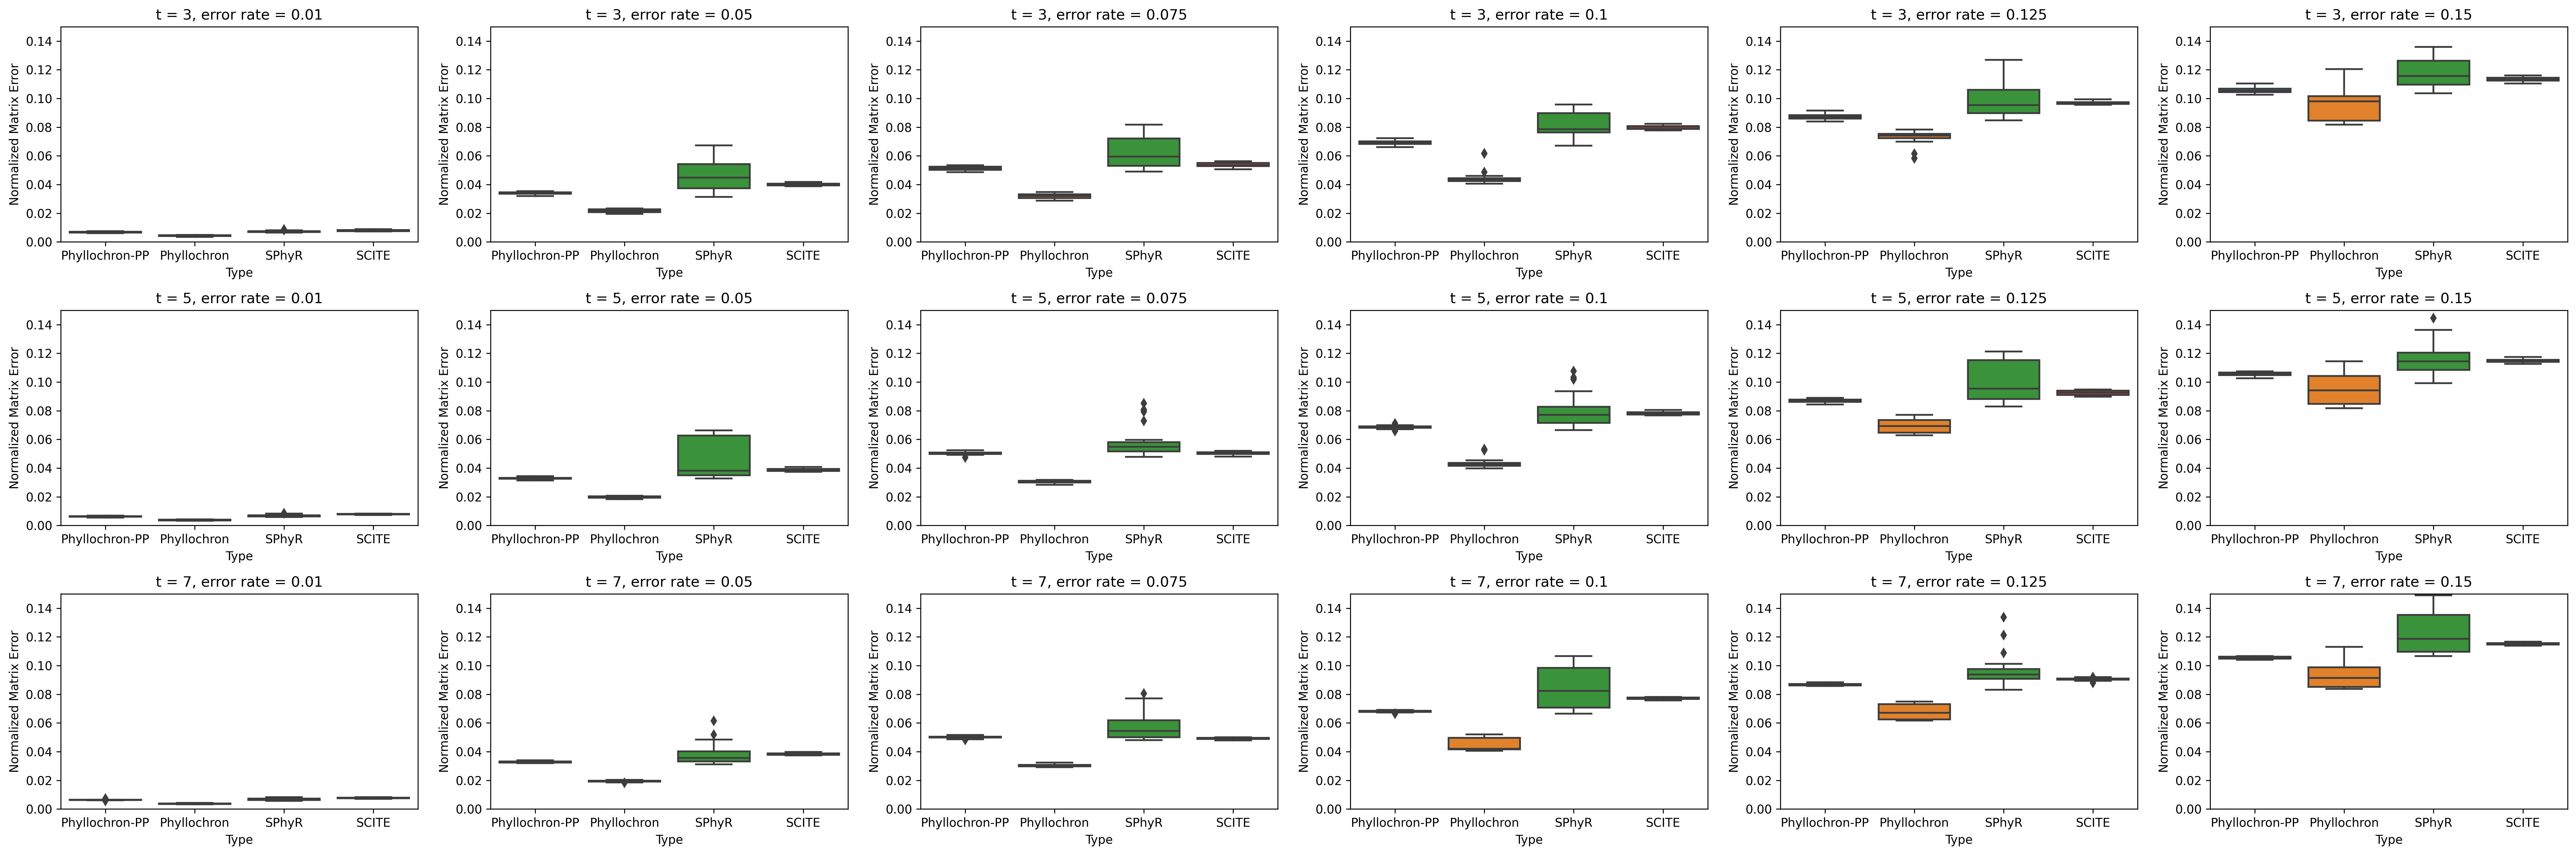

In [254]:
plt.figure()
fig, axs = plt.subplots(len(timepoints), len(error_rates), figsize=(30, 10))
for i, t in enumerate(timepoints):
    for j, prop in enumerate(error_rates):
        phyllochron_pp_diffs = []
        phyllochron_diffs = []
        SPhyR_diffs = []
        SCITE_diffs = []
        for sd in range(num_replicates + 1):
            if sd < num_replicates:
                og_character_matrix = pd.read_csv(f'../simulations/ground_truth/gt_imputation_{t}_{prop}_{sd}.csv').values[:, 1:]
                phyllochron_df = pd.read_csv(f'../simulations/Phyllochron/phyllochron_{t}_{prop}_{sd}_B.csv')
                phyllochron_pp_df = pd.read_csv(f'../simulations/Phyllochron_PP/phyllochron_pp_{t}_{prop}_{sd}_B.csv')
                sphyr_df = pd.read_csv(f'../simulations/SPhyR/sphyr_{t}_{prop}_{sd}.txt', sep=' ',skiprows=2, header=None)
                
                gv = pgv.AGraph(f'../simulations/SCITE/scite_{t}_{prop}_{sd}_ml0.gv', strict=False, directed=True)
                G = nx.DiGraph(gv)
                SCITE_character_matrix = build_matrix(G, t * ncells_per_sample, nmutations)
                
                SPhyR_character_matrix = sphyr_df.values
                phyllochron_character_matrix = phyllochron_df.values[:, 1:]
                phyllochron_pp_character_matrix = phyllochron_pp_df.values[:, 1:]
                            
                
                phyllochron_pp_diffs.append(np.sum(np.abs(og_character_matrix - phyllochron_pp_character_matrix))/(ncells_per_sample * nmutations * t))
                phyllochron_diffs.append(np.sum(np.abs(og_character_matrix - phyllochron_character_matrix))/(ncells_per_sample * nmutations * t))
                SPhyR_diffs.append(np.sum(np.abs(og_character_matrix - SPhyR_character_matrix))/(ncells_per_sample * nmutations * t))
                SCITE_diffs.append(np.sum(np.abs(og_character_matrix - SCITE_character_matrix))/(ncells_per_sample * nmutations * t))


        data = pd.DataFrame({'Type': num_replicates*['Phyllochron-PP'] + num_replicates*['Phyllochron'] + num_replicates*['SPhyR'] + num_replicates*['SCITE'], 'Normalized Matrix Error':phyllochron_pp_diffs + phyllochron_diffs + SPhyR_diffs + SCITE_diffs})
        axs[i,j].set_ylim(0, 0.15)
        sns.boxplot(x='Type', y='Normalized Matrix Error', data=data, ax = axs[i,j])
        axs[i,j].set_title(f't = {t}, error rate = {prop}')
fig.tight_layout()


plt.show()

### Line Plot

<Figure size 1800x1200 with 0 Axes>

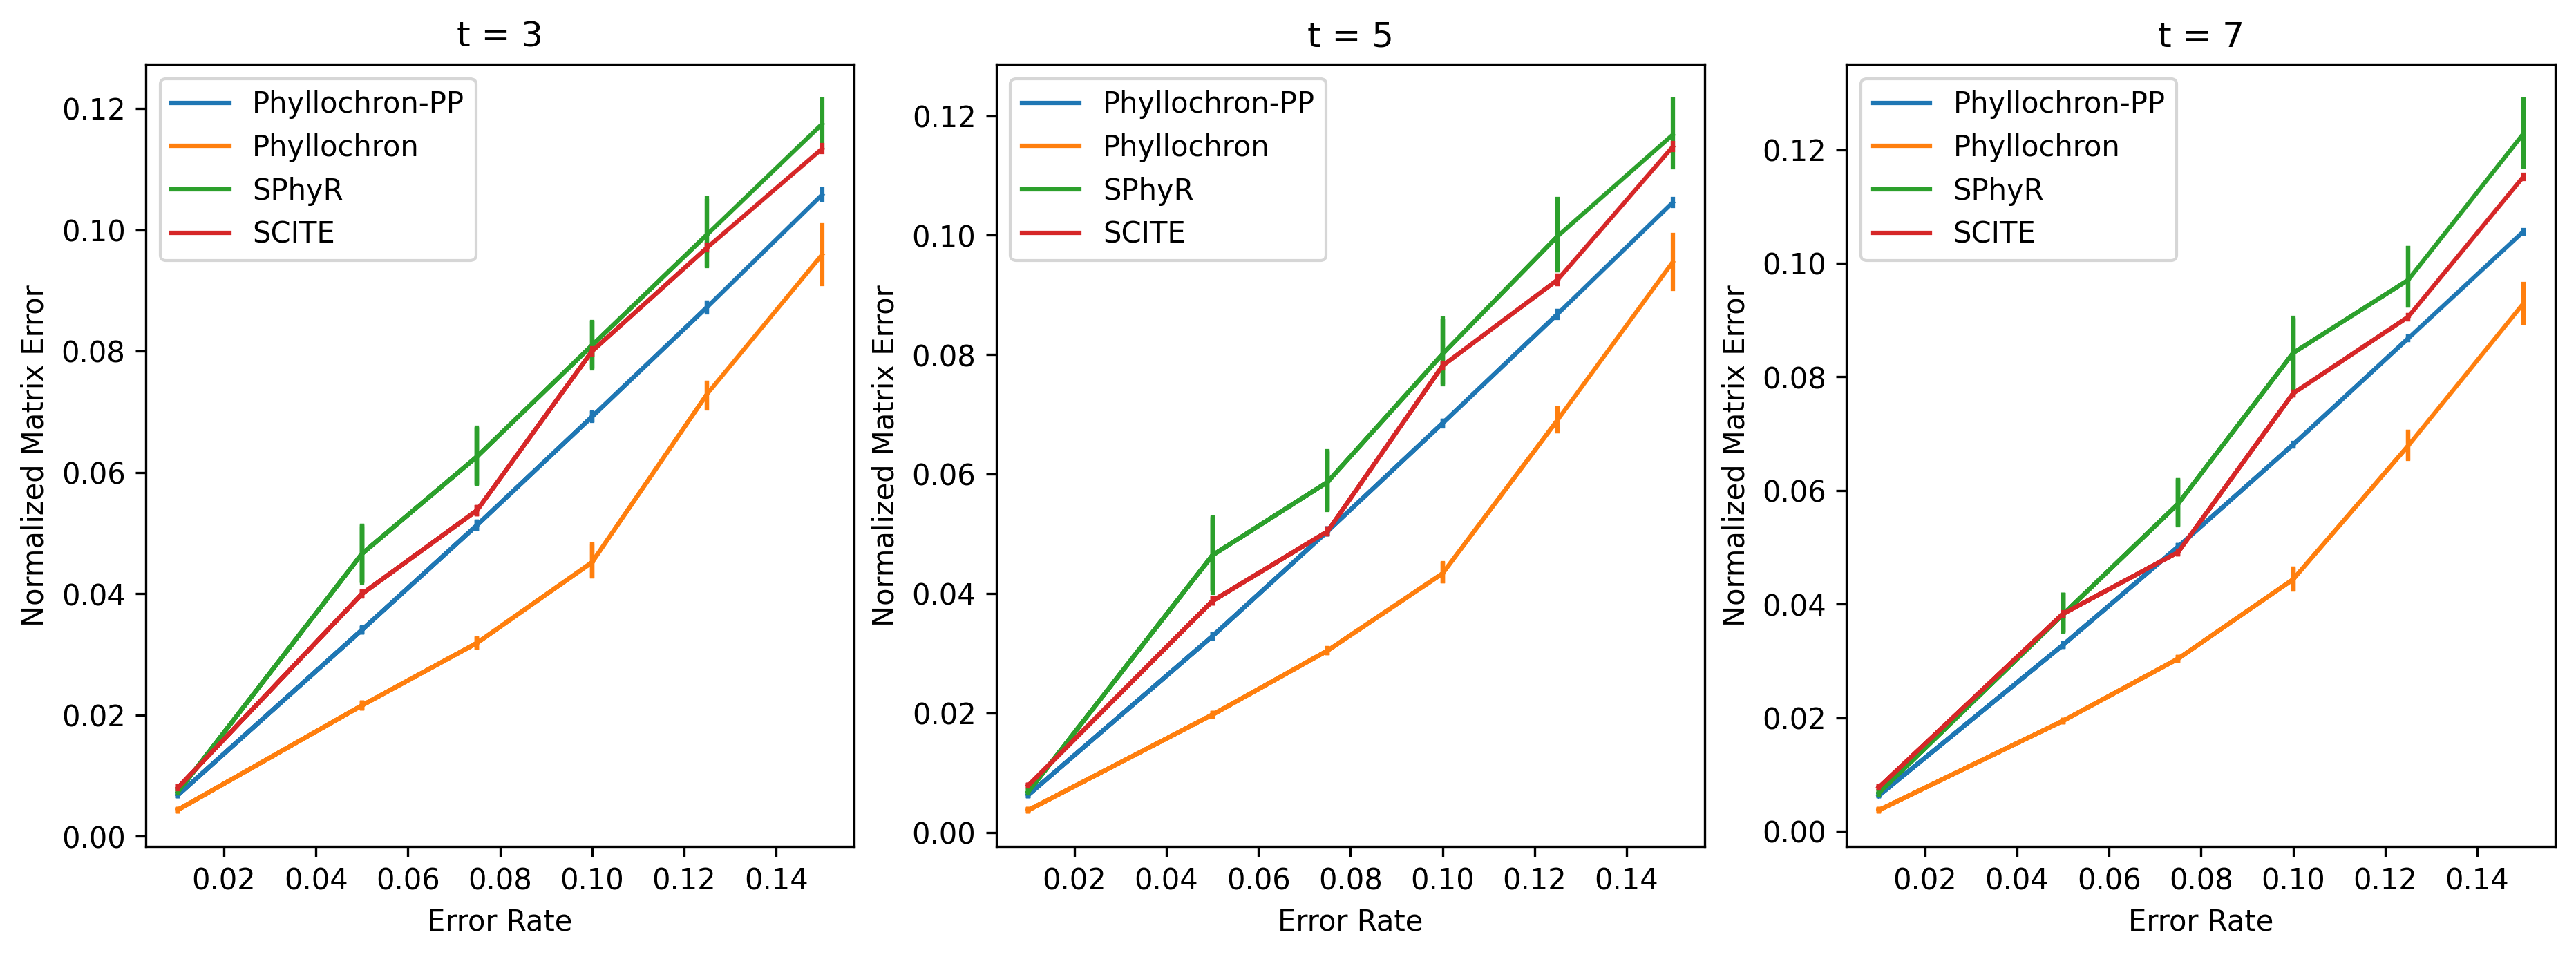

In [228]:
plt.figure()
fig, axs = plt.subplots(1, len(timepoints), figsize=(15, 5))
for i, t in enumerate(timepoints):
    all_data = []
    for j, prop in enumerate(error_rates):
        phyllochron_pp_diffs = []
        phyllochron_diffs = []
        SPhyR_diffs = []
        SCITE_diffs = []
        for sd in range(num_replicates + 1):
            if sd < num_replicates:
                og_character_matrix = pd.read_csv(f'../simulations/ground_truth/gt_imputation_{t}_{prop}_{sd}.csv').values[:, 1:]
                phyllochron_df = pd.read_csv(f'../simulations/Phyllochron/phyllochron_{t}_{prop}_{sd}_B.csv')
                phyllochron_pp_df = pd.read_csv(f'../simulations/Phyllochron_PP/phyllochron_pp_{t}_{prop}_{sd}_B.csv')
                sphyr_df = pd.read_csv(f'../simulations/SPhyR/sphyr_{t}_{prop}_{sd}.txt', sep=' ',skiprows=2, header=None)


                gv = pgv.AGraph(f'../simulations/SCITE/scite_{t}_{prop}_{sd}_ml0.gv', strict=False, directed=True)
                G = nx.DiGraph(gv)
                SCITE_character_matrix = build_matrix(G, t * ncells_per_sample, nmutations)
                
                SPhyR_character_matrix = sphyr_df.values
                phyllochron_character_matrix = phyllochron_df.values[:, 1:]
                phyllochron_pp_character_matrix = phyllochron_pp_df.values[:, 1:]
                phyllochron_pp_diffs.append(np.sum(np.abs(og_character_matrix - phyllochron_pp_character_matrix))/(ncells_per_sample * nmutations * t))
                phyllochron_diffs.append(np.sum(np.abs(og_character_matrix - phyllochron_character_matrix))/(ncells_per_sample * nmutations * t))
                SPhyR_diffs.append(np.sum(np.abs(og_character_matrix - SPhyR_character_matrix))/(ncells_per_sample * nmutations * t))
                SCITE_diffs.append(np.sum(np.abs(og_character_matrix - SCITE_character_matrix))/(ncells_per_sample * nmutations * t))


        data = pd.DataFrame({'Error Rate': (4*num_replicates)*[prop],'Type': num_replicates*['Phyllochron-PP'] + num_replicates*['Phyllochron'] + num_replicates*['SPhyR'] + num_replicates*['SCITE'], 'Normalized Matrix Error':phyllochron_pp_diffs + phyllochron_diffs + SPhyR_diffs + SCITE_diffs})
        #axs[i,j].set_ylim(0, 0.20)
        #sns.boxplot(x='Type', y='Normalized Matrix Error', data=data, ax = axs[i,j])
        axs[i].set_title(f't = {t}')
        all_data.append(data)
        data_final= pd.concat(all_data, axis=0, ignore_index=True)
        sns.lineplot(data=data_final, x='Error Rate', y="Normalized Matrix Error", hue="Type", err_style="bars", ax=axs[i])

# Apply function to each subplot
for ax in axs:
    remove_duplicate_legend_entries(ax)

plt.show()

## Plot Likelihood


<Figure size 1800x1200 with 0 Axes>

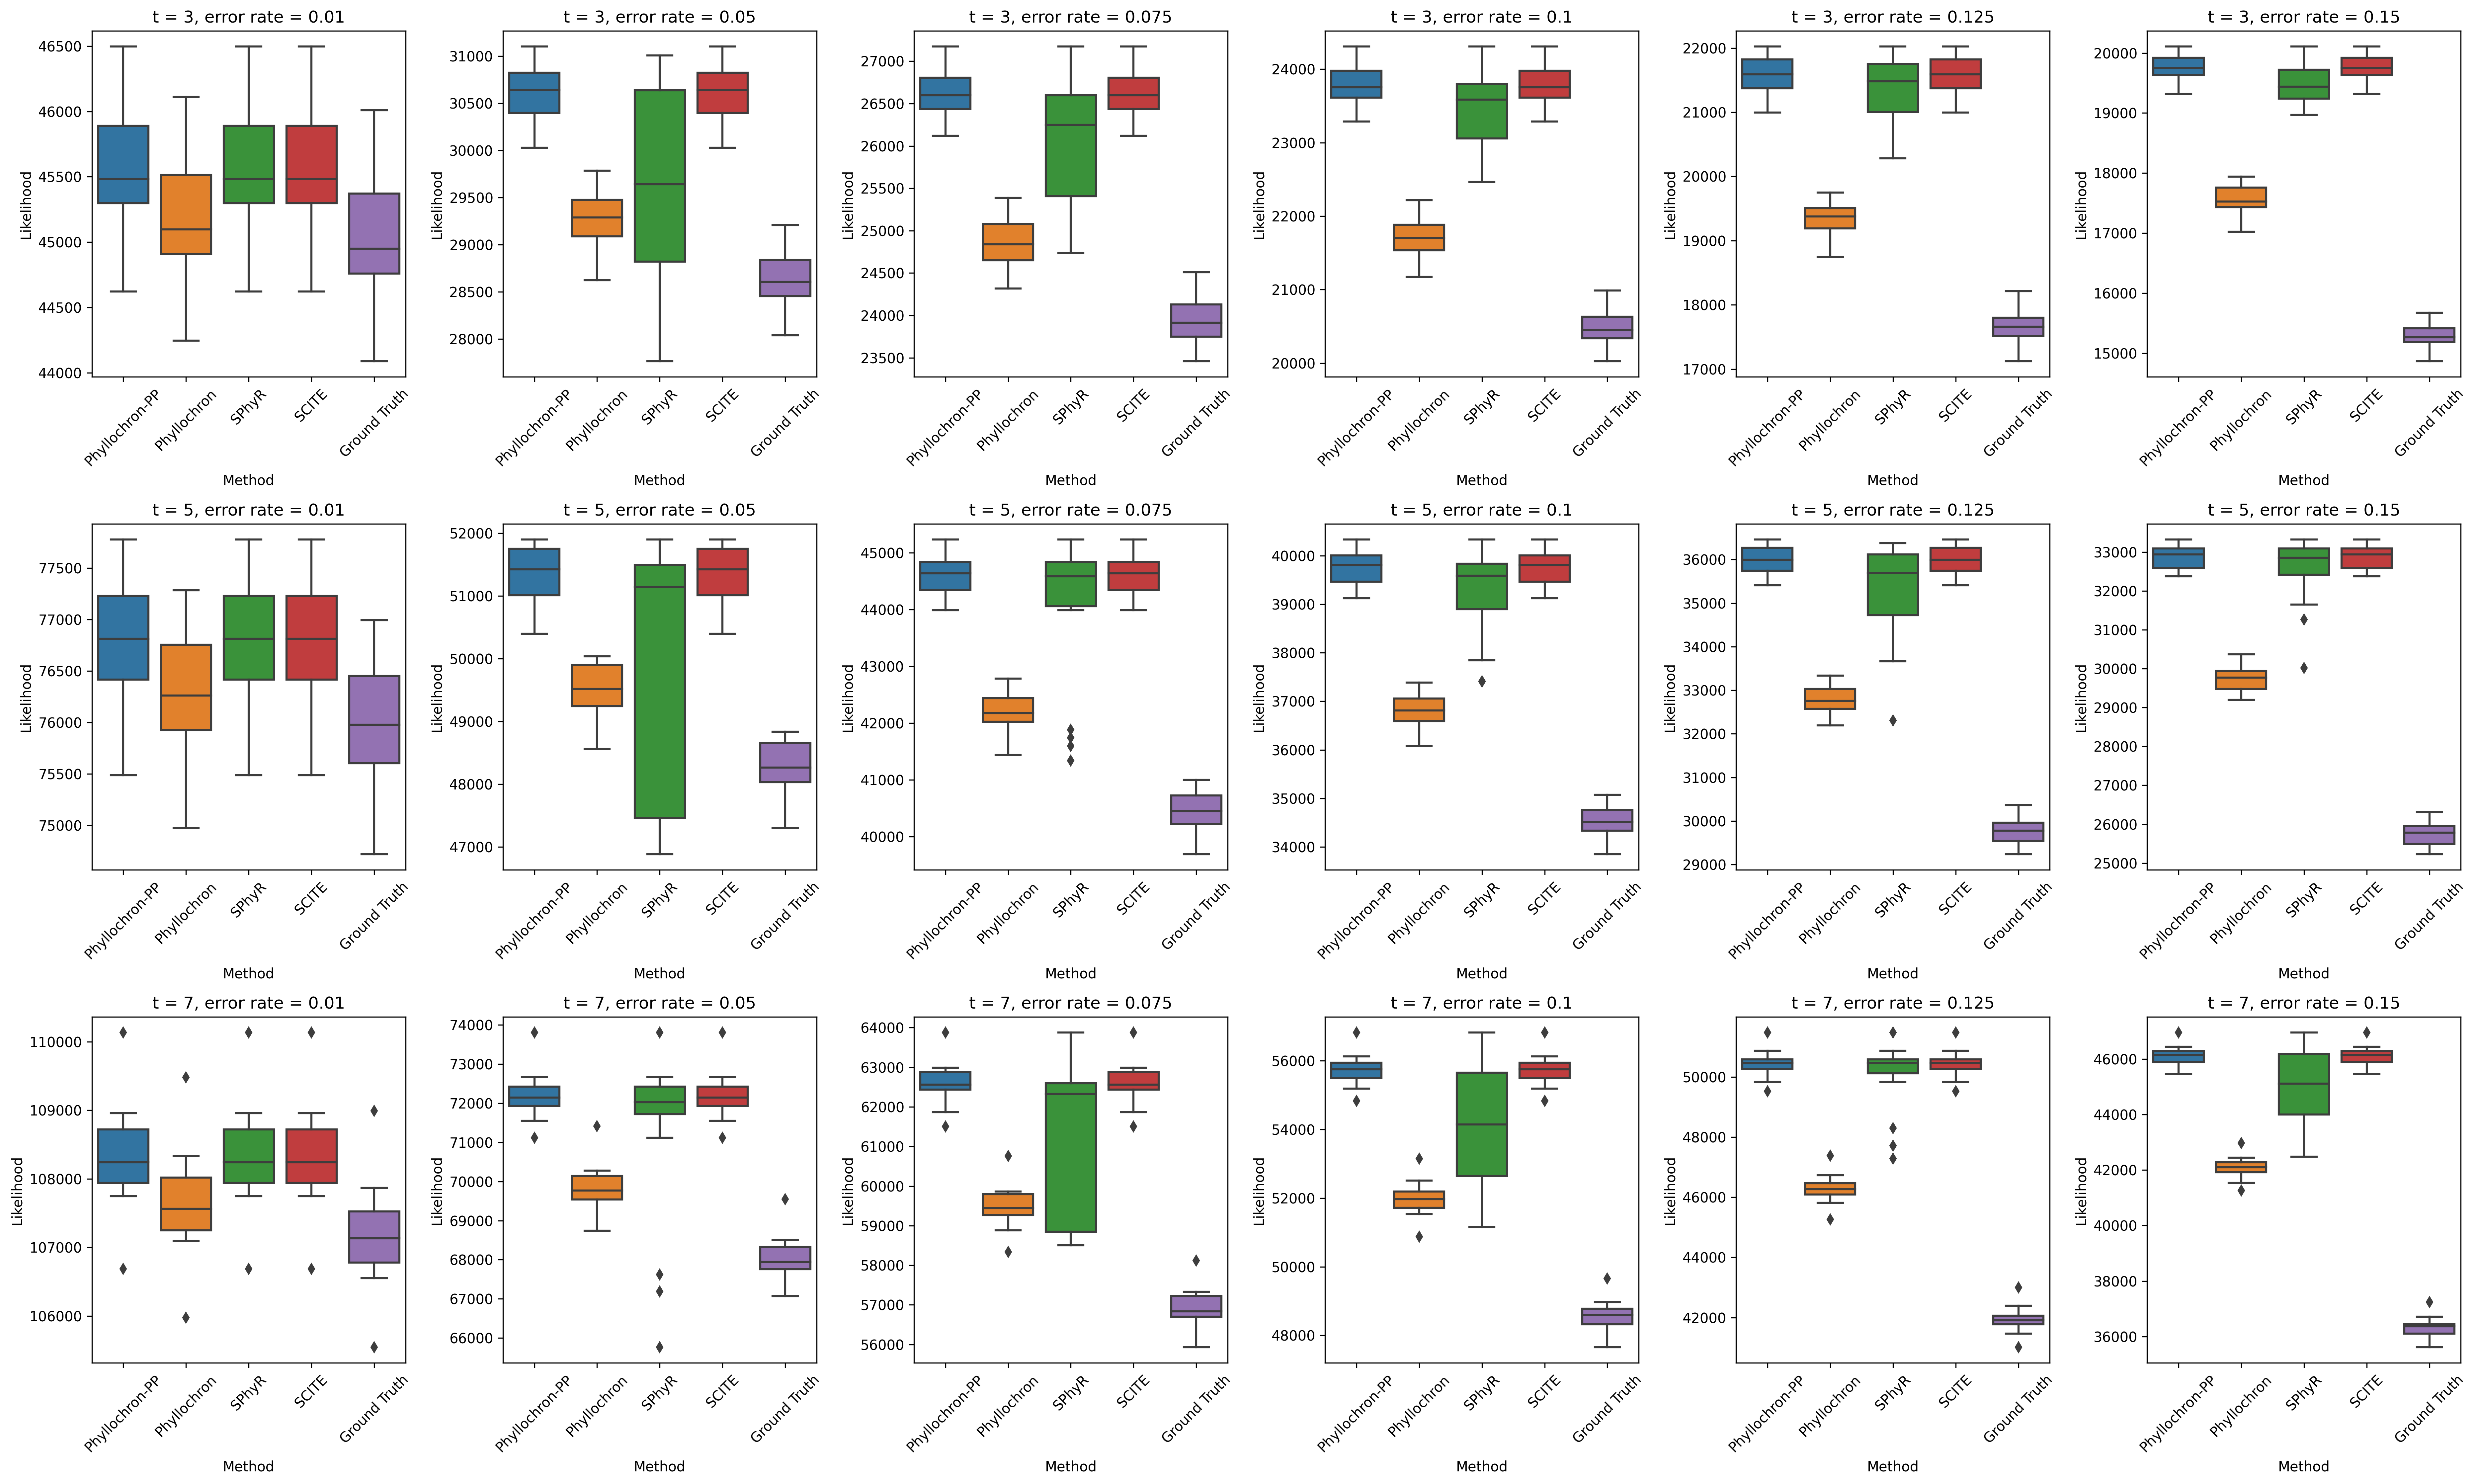

In [258]:
plt.figure()
fig, axs = plt.subplots(len(timepoints), len(error_rates), figsize=(25, 15))
for i, t in enumerate(timepoints):
    for j, prop in enumerate(error_rates):
        phyllochron_pp_diffs = []
        phyllochron_diffs = []
        SPhyR_diffs = []
        SCITE_diffs = []
        input_diffs = []
        for sd in range(num_replicates + 1):
            if sd < num_replicates:
                og_character_matrix = pd.read_csv(f'../simulations/ground_truth/gt_imputation_{t}_{prop}_{sd}.csv').values[:, 1:]
                phyllochron_df = pd.read_csv(f'../simulations/Phyllochron/phyllochron_{t}_{prop}_{sd}_B.csv')
                phyllochron_pp_df = pd.read_csv(f'../simulations/Phyllochron_PP/phyllochron_pp_{t}_{prop}_{sd}_B.csv')
                sphyr_df = pd.read_csv(f'../simulations/SPhyR/sphyr_{t}_{prop}_{sd}.txt', sep=' ',skiprows=2, header=None)
                input_df = pd.read_csv(f'../simulations/ground_truth/sphyr_{t}_{prop}_{sd}.txt', sep='\t',skiprows=2, header=None)


                gv = pgv.AGraph(f'../simulations/SCITE/scite_{t}_{prop}_{sd}_ml0.gv', strict=False, directed=True)
                G = nx.DiGraph(gv)
                SCITE_character_matrix = build_matrix(G, t * ncells_per_sample, nmutations)
                
                SPhyR_character_matrix = sphyr_df.values
                input_character_matrix = input_df.values.astype(int) 
                phyllochron_character_matrix = phyllochron_df.values[:, 1:]
                phyllochron_pp_character_matrix = phyllochron_pp_df.values[:, 1:]
                
                input_diffs.append(calculate_likelihood(input_character_matrix, og_character_matrix, prop))
                phyllochron_pp_diffs.append(calculate_likelihood(input_character_matrix,  phyllochron_pp_character_matrix, prop))
                phyllochron_diffs.append(calculate_likelihood(input_character_matrix, phyllochron_character_matrix, prop))
                SPhyR_diffs.append(calculate_likelihood(input_character_matrix, SPhyR_character_matrix, prop))
                SCITE_diffs.append(calculate_likelihood(input_character_matrix, SCITE_character_matrix, prop))
                if phyllochron_pp_diffs[-1] < phyllochron_diffs[-1]:
                    print(t, prop, phyllochron_pp_diffs[-1],  phyllochron_diffs[-1])
                

        data = pd.DataFrame({'Method': num_replicates*['Phyllochron-PP'] + num_replicates*['Phyllochron'] + num_replicates*['SPhyR'] + num_replicates*['SCITE'] + num_replicates*['Ground Truth'], 'Likelihood':phyllochron_pp_diffs + phyllochron_diffs + SPhyR_diffs + SCITE_diffs + input_diffs})
        axs[i,j].tick_params(axis='x', labelrotation=45)
        #axs[i,j].set_ylim(12000, 120000)
        sns.boxplot(x='Method', y='Likelihood', data=data, ax = axs[i,j])
        axs[i,j].set_title(f't = {t}, error rate = {prop}')

fig.tight_layout()       
plt.show()

## Plot Clonal Lifespan Accuracy

### Box Plot

<Figure size 1800x1200 with 0 Axes>

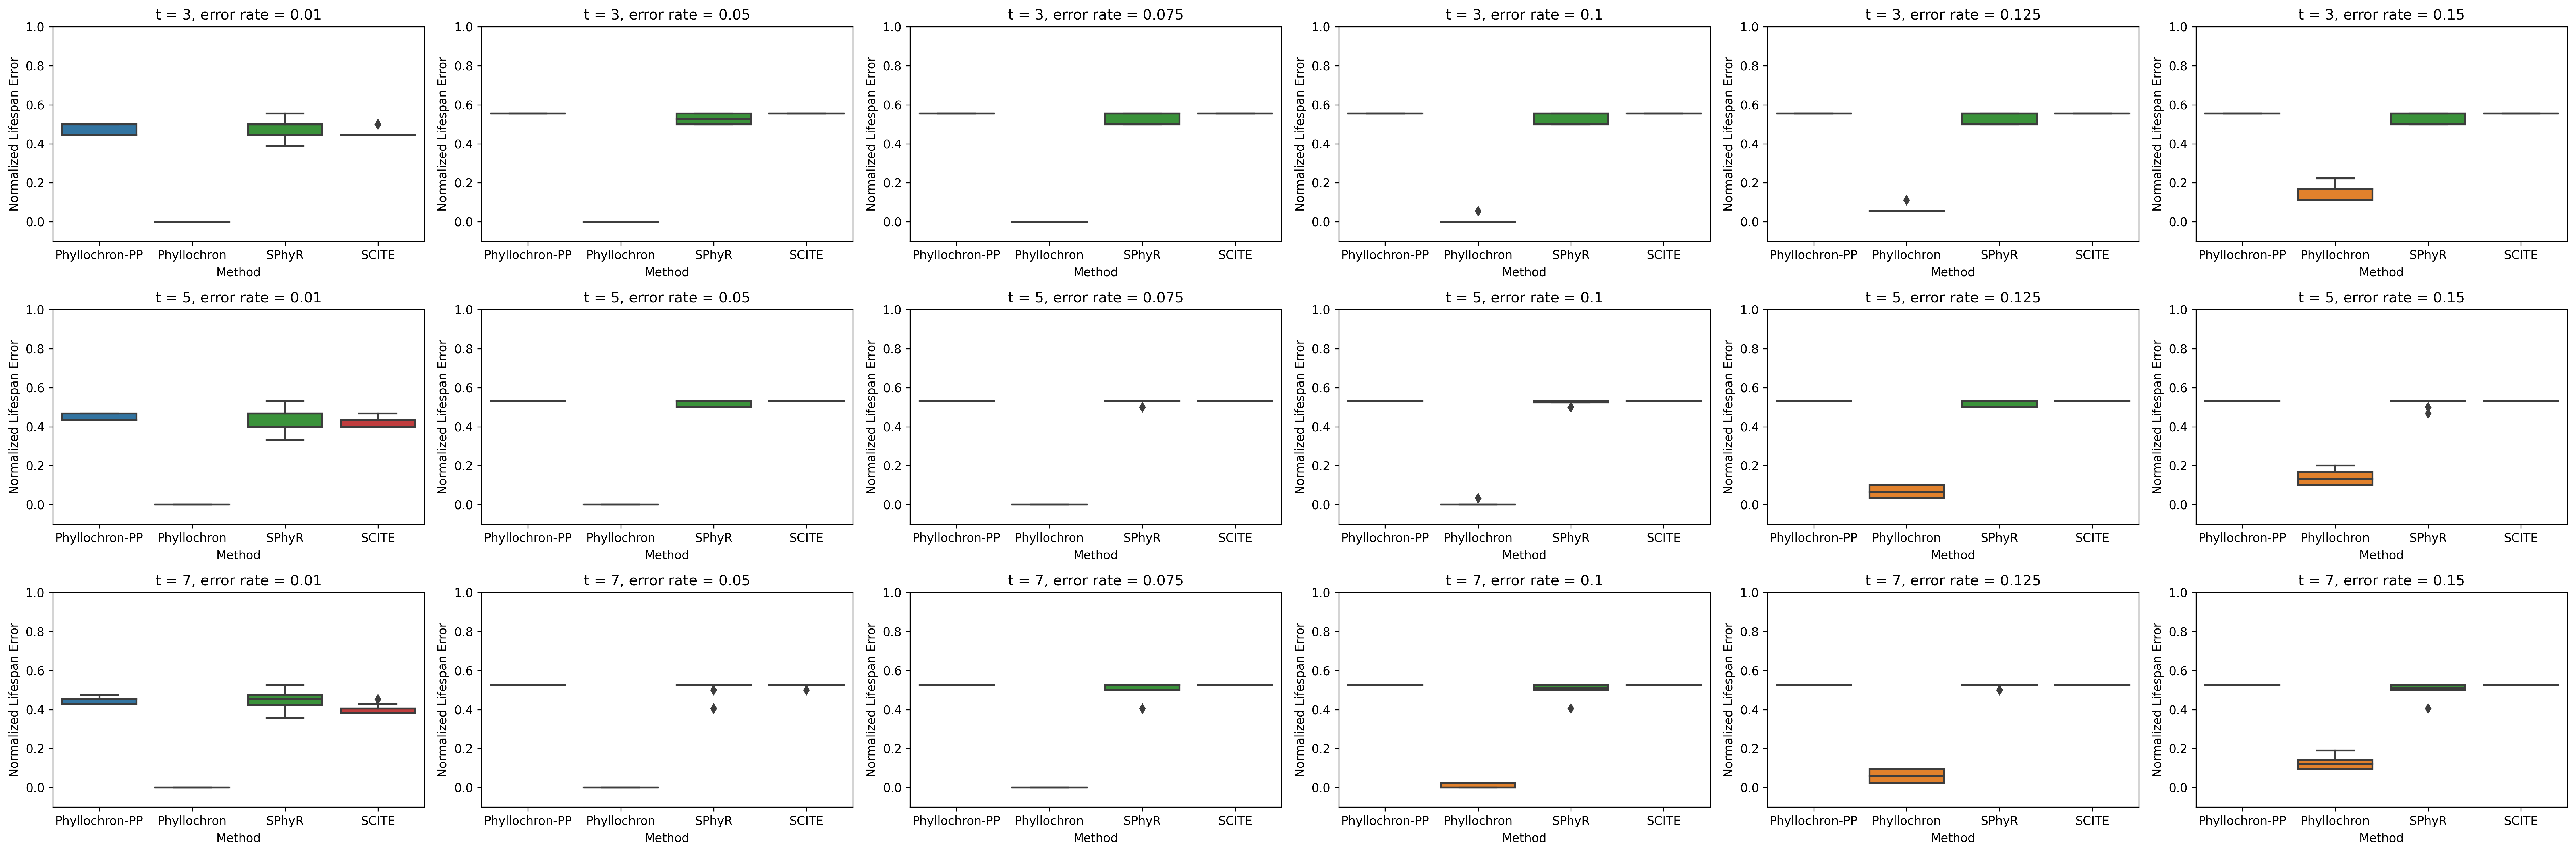

In [256]:
plt.figure()
fig, axs = plt.subplots(len(timepoints), len(error_rates), figsize=(30, 10))
for i, t in enumerate(timepoints):
    for j, prop in enumerate(error_rates):
        phyllochron_pp_diffs = []
        phyllochron_diffs = []
        SPhyR_diffs = []
        SCITE_diffs = []
        for sd in range(num_replicates + 1):
            if sd < num_replicates:
                og_character_matrix = pd.read_csv(f'../simulations/ground_truth/gt_imputation_{t}_{prop}_{sd}.csv').values[:, 1:]
                original_map = defaultdict(set)
                timepoint_count = defaultdict()
                for r in range(og_character_matrix.shape[0]):
                    if " ".join(map(str, map(int, og_character_matrix[r]))) not in timepoint_count.keys():
                        timepoint_count[" ".join(map(str, map(int, og_character_matrix[r])))] = defaultdict(int)
                    timepoint_count[" ".join(map(str, map(int, og_character_matrix[r])))][r//ncells_per_sample] += 1
                    if timepoint_count[" ".join(map(str, map(int, og_character_matrix[r])))][r//ncells_per_sample] >= 0:
                        original_map[" ".join(map(str, map(int, og_character_matrix[r])))].add(r//ncells_per_sample)
                

                phyllochron_df = pd.read_csv(f'../simulations/Phyllochron/phyllochron_{t}_{prop}_{sd}_B.csv')
                phyllochron_pp_df = pd.read_csv(f'../simulations/Phyllochron_PP/phyllochron_pp_{t}_{prop}_{sd}_B.csv')
                sphyr_df = pd.read_csv(f'../simulations/SPhyR/sphyr_{t}_{prop}_{sd}.txt', sep=' ',skiprows=2, header=None)
                
                gv = pgv.AGraph(f'../simulations/SCITE/scite_{t}_{prop}_{sd}_ml0.gv', strict=False, directed=True)
                G = nx.DiGraph(gv)
                SCITE_character_matrix = build_matrix(G, t * ncells_per_sample, nmutations)
                
                SPhyR_character_matrix = sphyr_df.values
                phyllochron_character_matrix = phyllochron_df.values[:, 1:]
                phyllochron_pp_character_matrix = phyllochron_pp_df.values[:, 1:]
                phyllochron_pp_diffs.append(clonal_accuracy(original_map, phyllochron_pp_character_matrix, ncells_per_sample, opt=400)/((nmutations + 1) * t))
                phyllochron_diffs.append(clonal_accuracy(original_map , phyllochron_character_matrix, ncells_per_sample,opt=400)/((nmutations + 1) * t))
                SPhyR_diffs.append(clonal_accuracy(original_map , SPhyR_character_matrix, ncells_per_sample,  opt=400)/((nmutations + 1) * t))
                SCITE_diffs.append(clonal_accuracy(original_map , SCITE_character_matrix, ncells_per_sample, opt=400)/((nmutations + 1) * t))

        data = pd.DataFrame({'Method': num_replicates*['Phyllochron-PP'] + num_replicates*['Phyllochron'] + num_replicates*['SPhyR'] + num_replicates*['SCITE'],'Normalized Lifespan Error':phyllochron_pp_diffs + phyllochron_diffs + SPhyR_diffs + SCITE_diffs})
        axs[i,j].set_ylim(-0.1, 1.00)
        sns.boxplot(x='Method', y='Normalized Lifespan Error', data=data, ax = axs[i,j])
        axs[i,j].set_title(f't = {t}, error rate = {prop}')
fig.tight_layout()
plt.show()

### Line Plot

<Figure size 1800x1200 with 0 Axes>

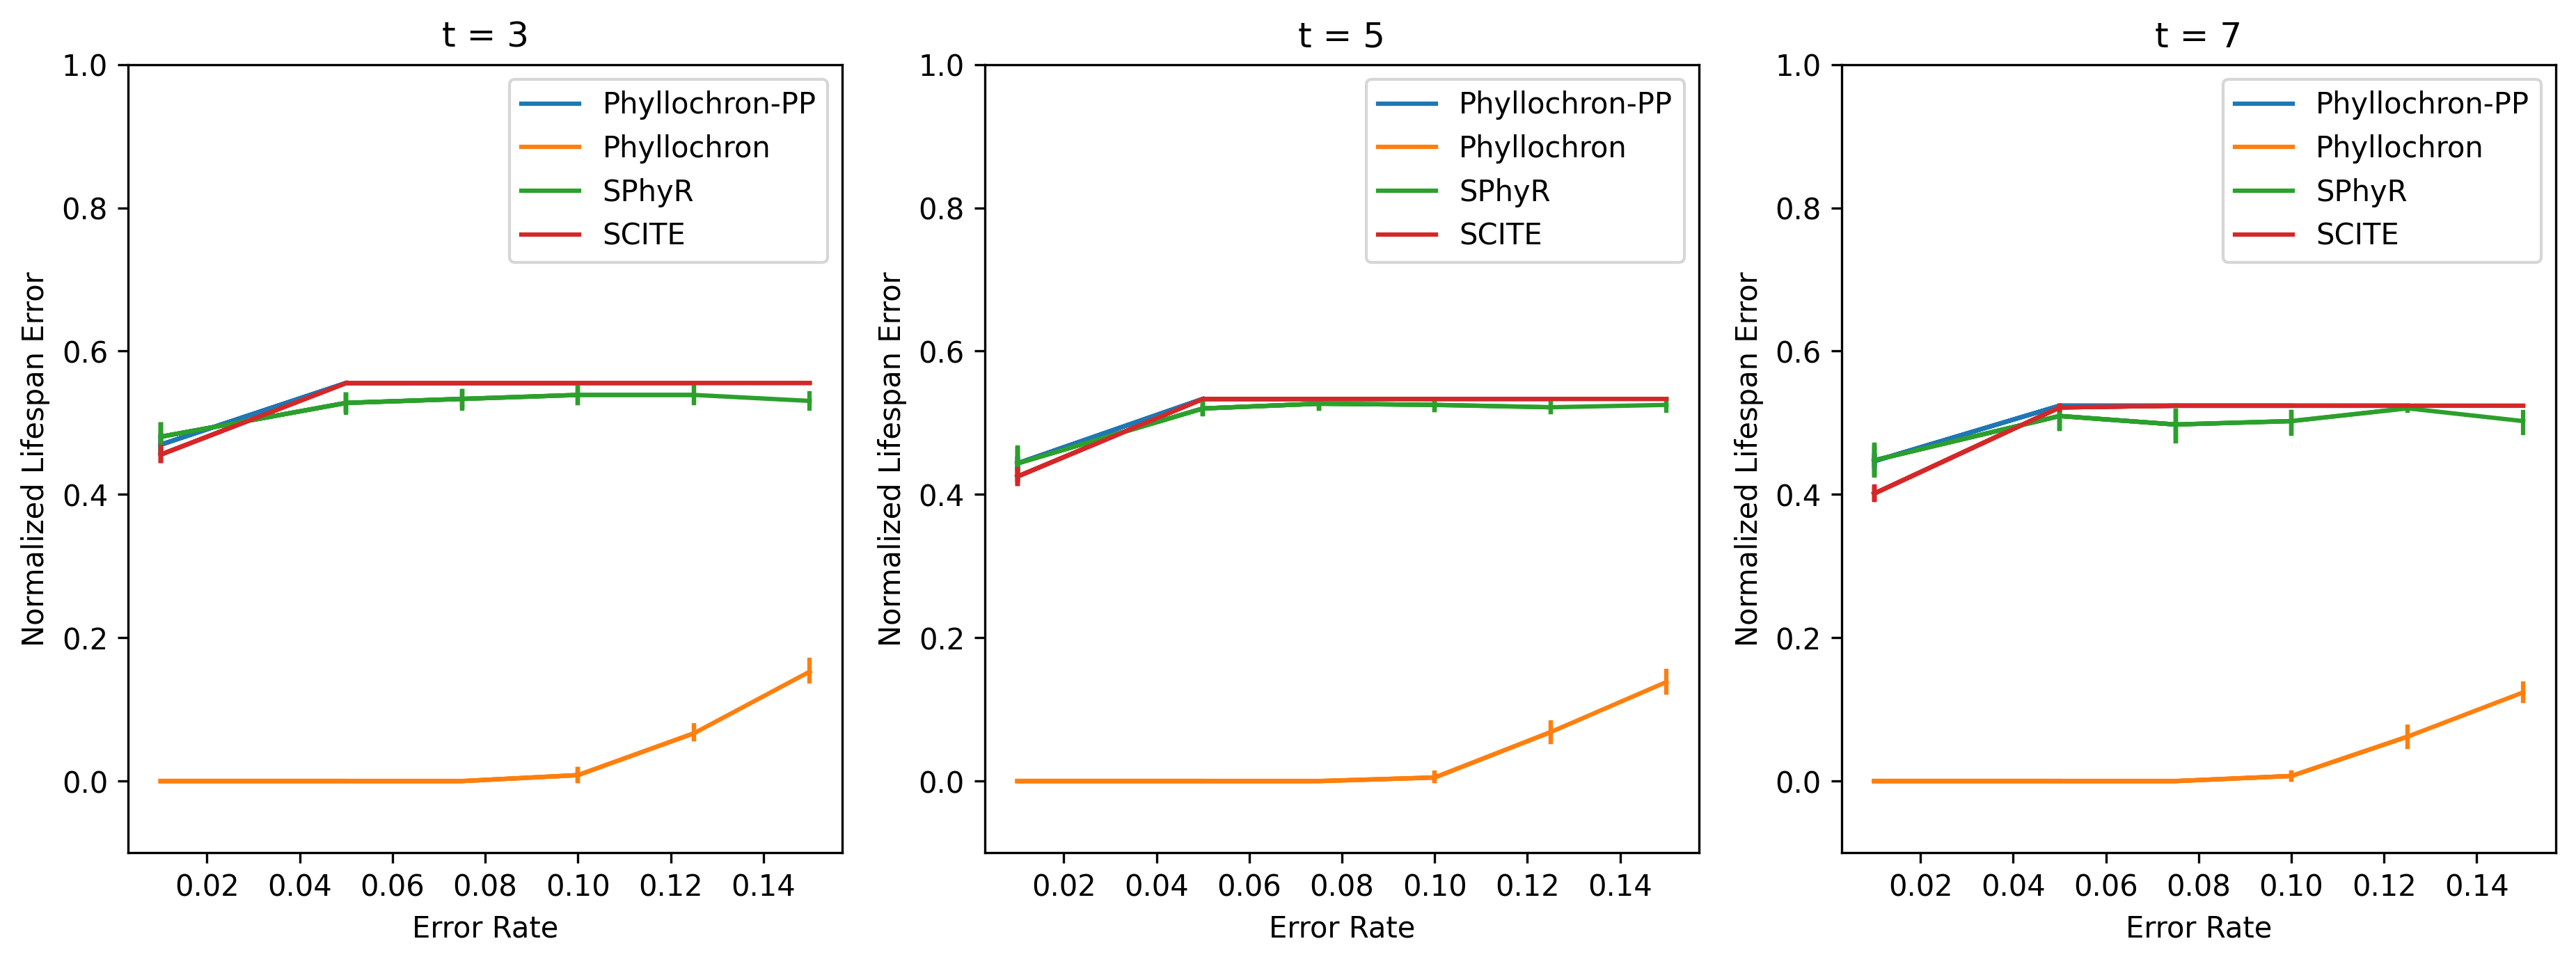

In [231]:
plt.figure()
fig, axs = plt.subplots(1, len(timepoints), figsize=(15, 5))
for i, t in enumerate(timepoints):
    all_data = []
    for j, prop in enumerate(error_rates):
        phyllochron_pp_diffs = []
        phyllochron_diffs = []
        SPhyR_diffs = []
        SCITE_diffs = []
        for sd in range(num_replicates + 1):
            if sd < num_replicates:
                og_character_matrix = pd.read_csv(f'../simulations/ground_truth/gt_imputation_{t}_{prop}_{sd}.csv').values[:, 1:]
                original_map = defaultdict(set)
                timepoint_count = defaultdict()
                for r in range(og_character_matrix.shape[0]):
                    if " ".join(map(str, map(int, og_character_matrix[r]))) not in timepoint_count.keys():
                        timepoint_count[" ".join(map(str, map(int, og_character_matrix[r])))] = defaultdict(int)
                    timepoint_count[" ".join(map(str, map(int, og_character_matrix[r])))][r//ncells_per_sample] += 1
                    if timepoint_count[" ".join(map(str, map(int, og_character_matrix[r])))][r//ncells_per_sample] >= 0:
                        original_map[" ".join(map(str, map(int, og_character_matrix[r])))].add(r//ncells_per_sample)

                
                phyllochron_df = pd.read_csv(f'../simulations/Phyllochron/phyllochron_{t}_{prop}_{sd}_B.csv')
                phyllochron_pp_df = pd.read_csv(f'../simulations/Phyllochron_PP/phyllochron_pp_{t}_{prop}_{sd}_B.csv')
                sphyr_df = pd.read_csv(f'../simulations/SPhyR/sphyr_{t}_{prop}_{sd}.txt', sep=' ',skiprows=2, header=None)
                
                gv = pgv.AGraph(f'../simulations/SCITE/scite_{t}_{prop}_{sd}_ml0.gv', strict=False, directed=True)
                G = nx.DiGraph(gv)
                SCITE_character_matrix = build_matrix(G, t * ncells_per_sample, nmutations)
                
                SPhyR_character_matrix = sphyr_df.values
                phyllochron_character_matrix = phyllochron_df.values[:, 1:]
                phyllochron_pp_character_matrix = phyllochron_pp_df.values[:, 1:]
                phyllochron_pp_diffs.append(clonal_accuracy(original_map, phyllochron_pp_character_matrix, ncells_per_sample, opt=400)/((nmutations + 1) * t))
                phyllochron_diffs.append(clonal_accuracy(original_map , phyllochron_character_matrix, ncells_per_sample,opt=400)/((nmutations + 1) * t))
                SPhyR_diffs.append(clonal_accuracy(original_map , SPhyR_character_matrix, ncells_per_sample,  opt=400)/((nmutations + 1) * t))
                SCITE_diffs.append(clonal_accuracy(original_map , SCITE_character_matrix, ncells_per_sample, opt=400)/((nmutations + 1) * t))



        data = pd.DataFrame({'Error Rate': (4*num_replicates)*[prop],'Type': num_replicates*['Phyllochron-PP'] + num_replicates*['Phyllochron'] + num_replicates*['SPhyR'] + num_replicates*['SCITE'], 'Normalized Lifespan Error':phyllochron_pp_diffs + phyllochron_diffs + SPhyR_diffs + SCITE_diffs})

        axs[i].set_title(f't = {t}')
        axs[i].set_ylim(-0.1, 1.00)
        all_data.append(data)
        data_final= pd.concat(all_data, axis=0, ignore_index=True)
        sns.lineplot(data=data_final, x='Error Rate', y="Normalized Lifespan Error", hue="Type", err_style ="bars", ax=axs[i])

# Apply function to each subplot
for ax in axs:
    remove_duplicate_legend_entries(ax)

plt.show()

### Plot Tree Accuracy

<Figure size 1800x1200 with 0 Axes>

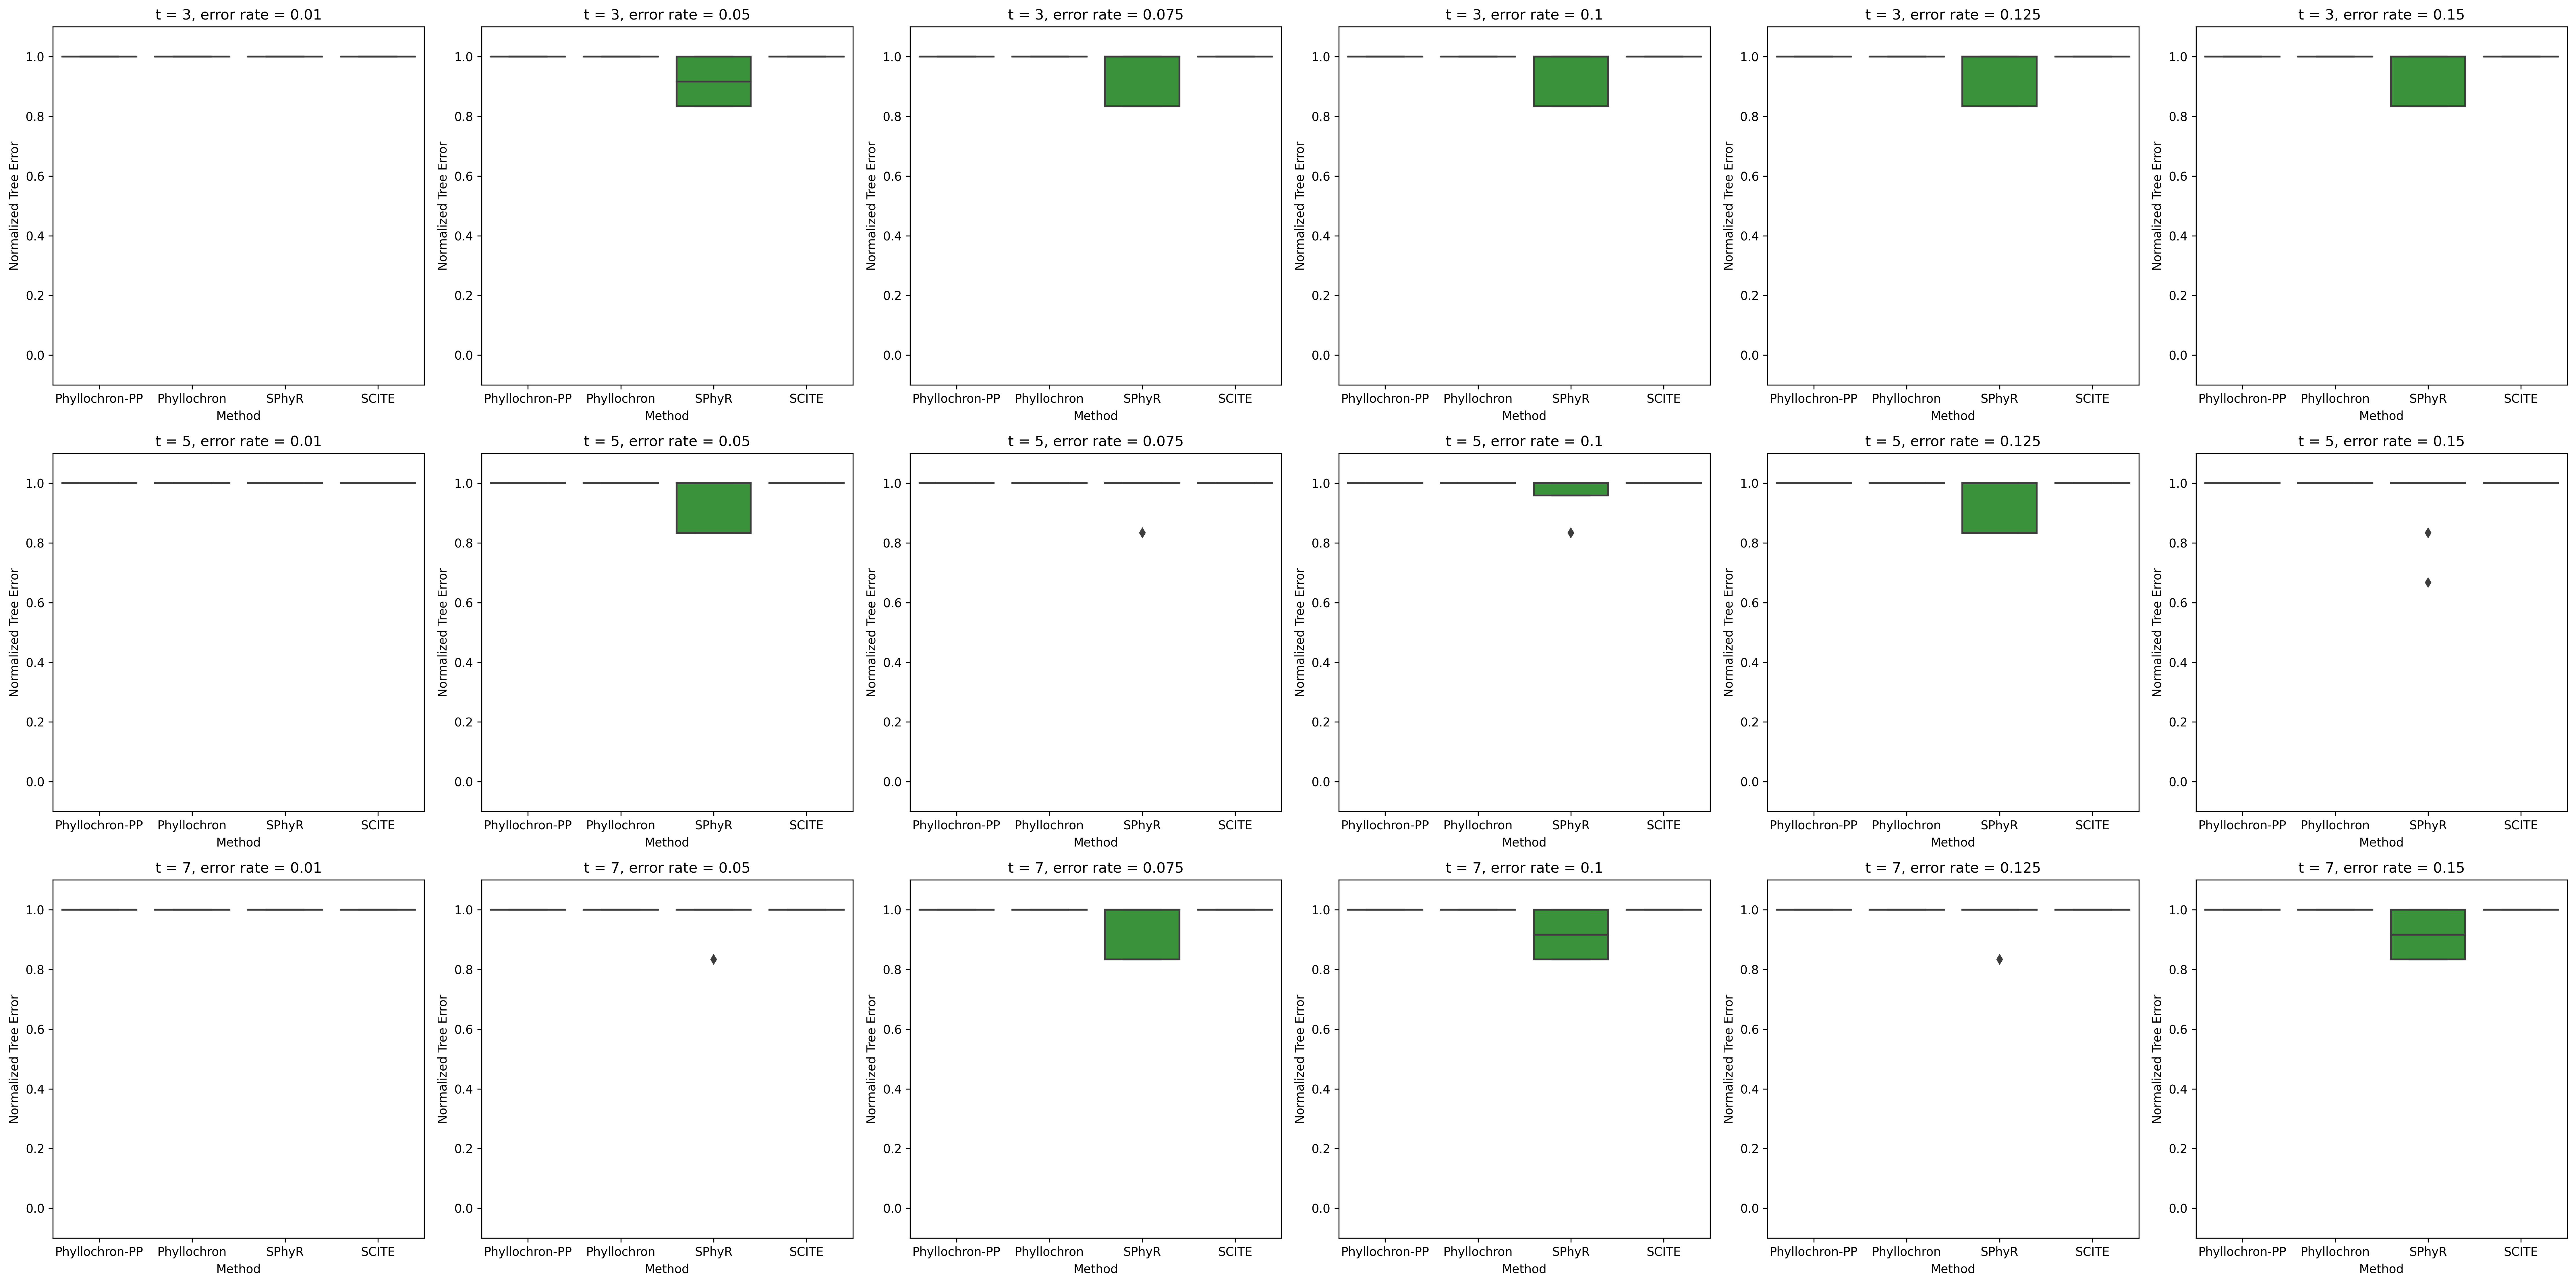

In [271]:
plt.figure()
fig, axs = plt.subplots(len(timepoints), len(error_rates), figsize=(30, 15))
for i, t in enumerate(timepoints):
    for j, prop in enumerate(error_rates):
        phyllochron_pp_diffs = []
        phyllochron_diffs = []
        SPhyR_diffs = []
        SCITE_diffs = []
        for sd in range(num_replicates + 1):
            if sd < num_replicates:
                og_character_matrix = pd.read_csv(f'../simulations/ground_truth/gt_imputation_{t}_{prop}_{sd}.csv').values[:, 1:]
                phyllochron_df = pd.read_csv(f'../simulations/Phyllochron/phyllochron_{t}_{prop}_{sd}_B.csv')
                phyllochron_pp_df = pd.read_csv(f'../simulations/Phyllochron_PP/phyllochron_pp_{t}_{prop}_{sd}_B.csv')
                sphyr_df = pd.read_csv(f'../simulations/SPhyR/sphyr_{t}_{prop}_{sd}.txt', sep=' ',skiprows=2, header=None)
                
                gv = pgv.AGraph(f'../simulations/SCITE/scite_{t}_{prop}_{sd}_ml0.gv', strict=False, directed=True)
                G = nx.DiGraph(gv)
                SCITE_character_matrix = build_matrix(G, t * ncells_per_sample, nmutations)
                
                
                SPhyR_character_matrix = sphyr_df.values
                phyllochron_character_matrix = phyllochron_df.values[:, 1:]
                phyllochron_pp_character_matrix = phyllochron_pp_df.values[:, 1:]
            
                phyllochron_pp_diffs.append(return_score(sort_rows_by_binary_encoding(np.unique(og_character_matrix.astype(int),axis=0)), sort_rows_by_binary_encoding(np.unique(phyllochron_pp_character_matrix, axis=0)))/((nmutations + 1)))
                phyllochron_diffs.append(return_score(sort_rows_by_binary_encoding(np.unique(og_character_matrix.astype(int),axis=0)), sort_rows_by_binary_encoding(np.unique(phyllochron_character_matrix, axis=0)))/((nmutations + 1)))
                SPhyR_diffs.append(return_score(sort_rows_by_binary_encoding(np.unique(og_character_matrix.astype(int),axis=0)),  sort_rows_by_binary_encoding(np.unique(SPhyR_character_matrix.astype(int),axis=0)))/((nmutations + 1)))
                SCITE_diffs.append(return_score(sort_rows_by_binary_encoding(np.unique(og_character_matrix.astype(int),axis=0)), sort_rows_by_binary_encoding(np.unique(SCITE_character_matrix.astype(int), axis=0)))/((nmutations + 1) ))

            idx += 1

        data = pd.DataFrame({'Method': num_replicates*['Phyllochron-PP'] + num_replicates*['Phyllochron'] + num_replicates*['SPhyR'] + num_replicates*['SCITE'],'Normalized Tree Error':phyllochron_pp_diffs + phyllochron_diffs + SPhyR_diffs + SCITE_diffs})

        axs[i,j].set_ylim(-0.100, 1.1)

        sns.boxplot(x='Method', y='Normalized Tree Error', data=data, ax = axs[i,j])
        axs[i,j].set_title(f't = {t}, error rate = {prop}')
fig.tight_layout()
plt.show()

# Readcount Methods Comparison

### Parameters

In [259]:
# Variable Parameters 
ncells_per_sample = 100
timepoints = [3, 5, 7]
error_rates = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
num_replicates = 20

# Fixed Parameters
nmutations = 5

## Plot Normalized Matrix Error

### Box Plot

<Figure size 1800x1200 with 0 Axes>

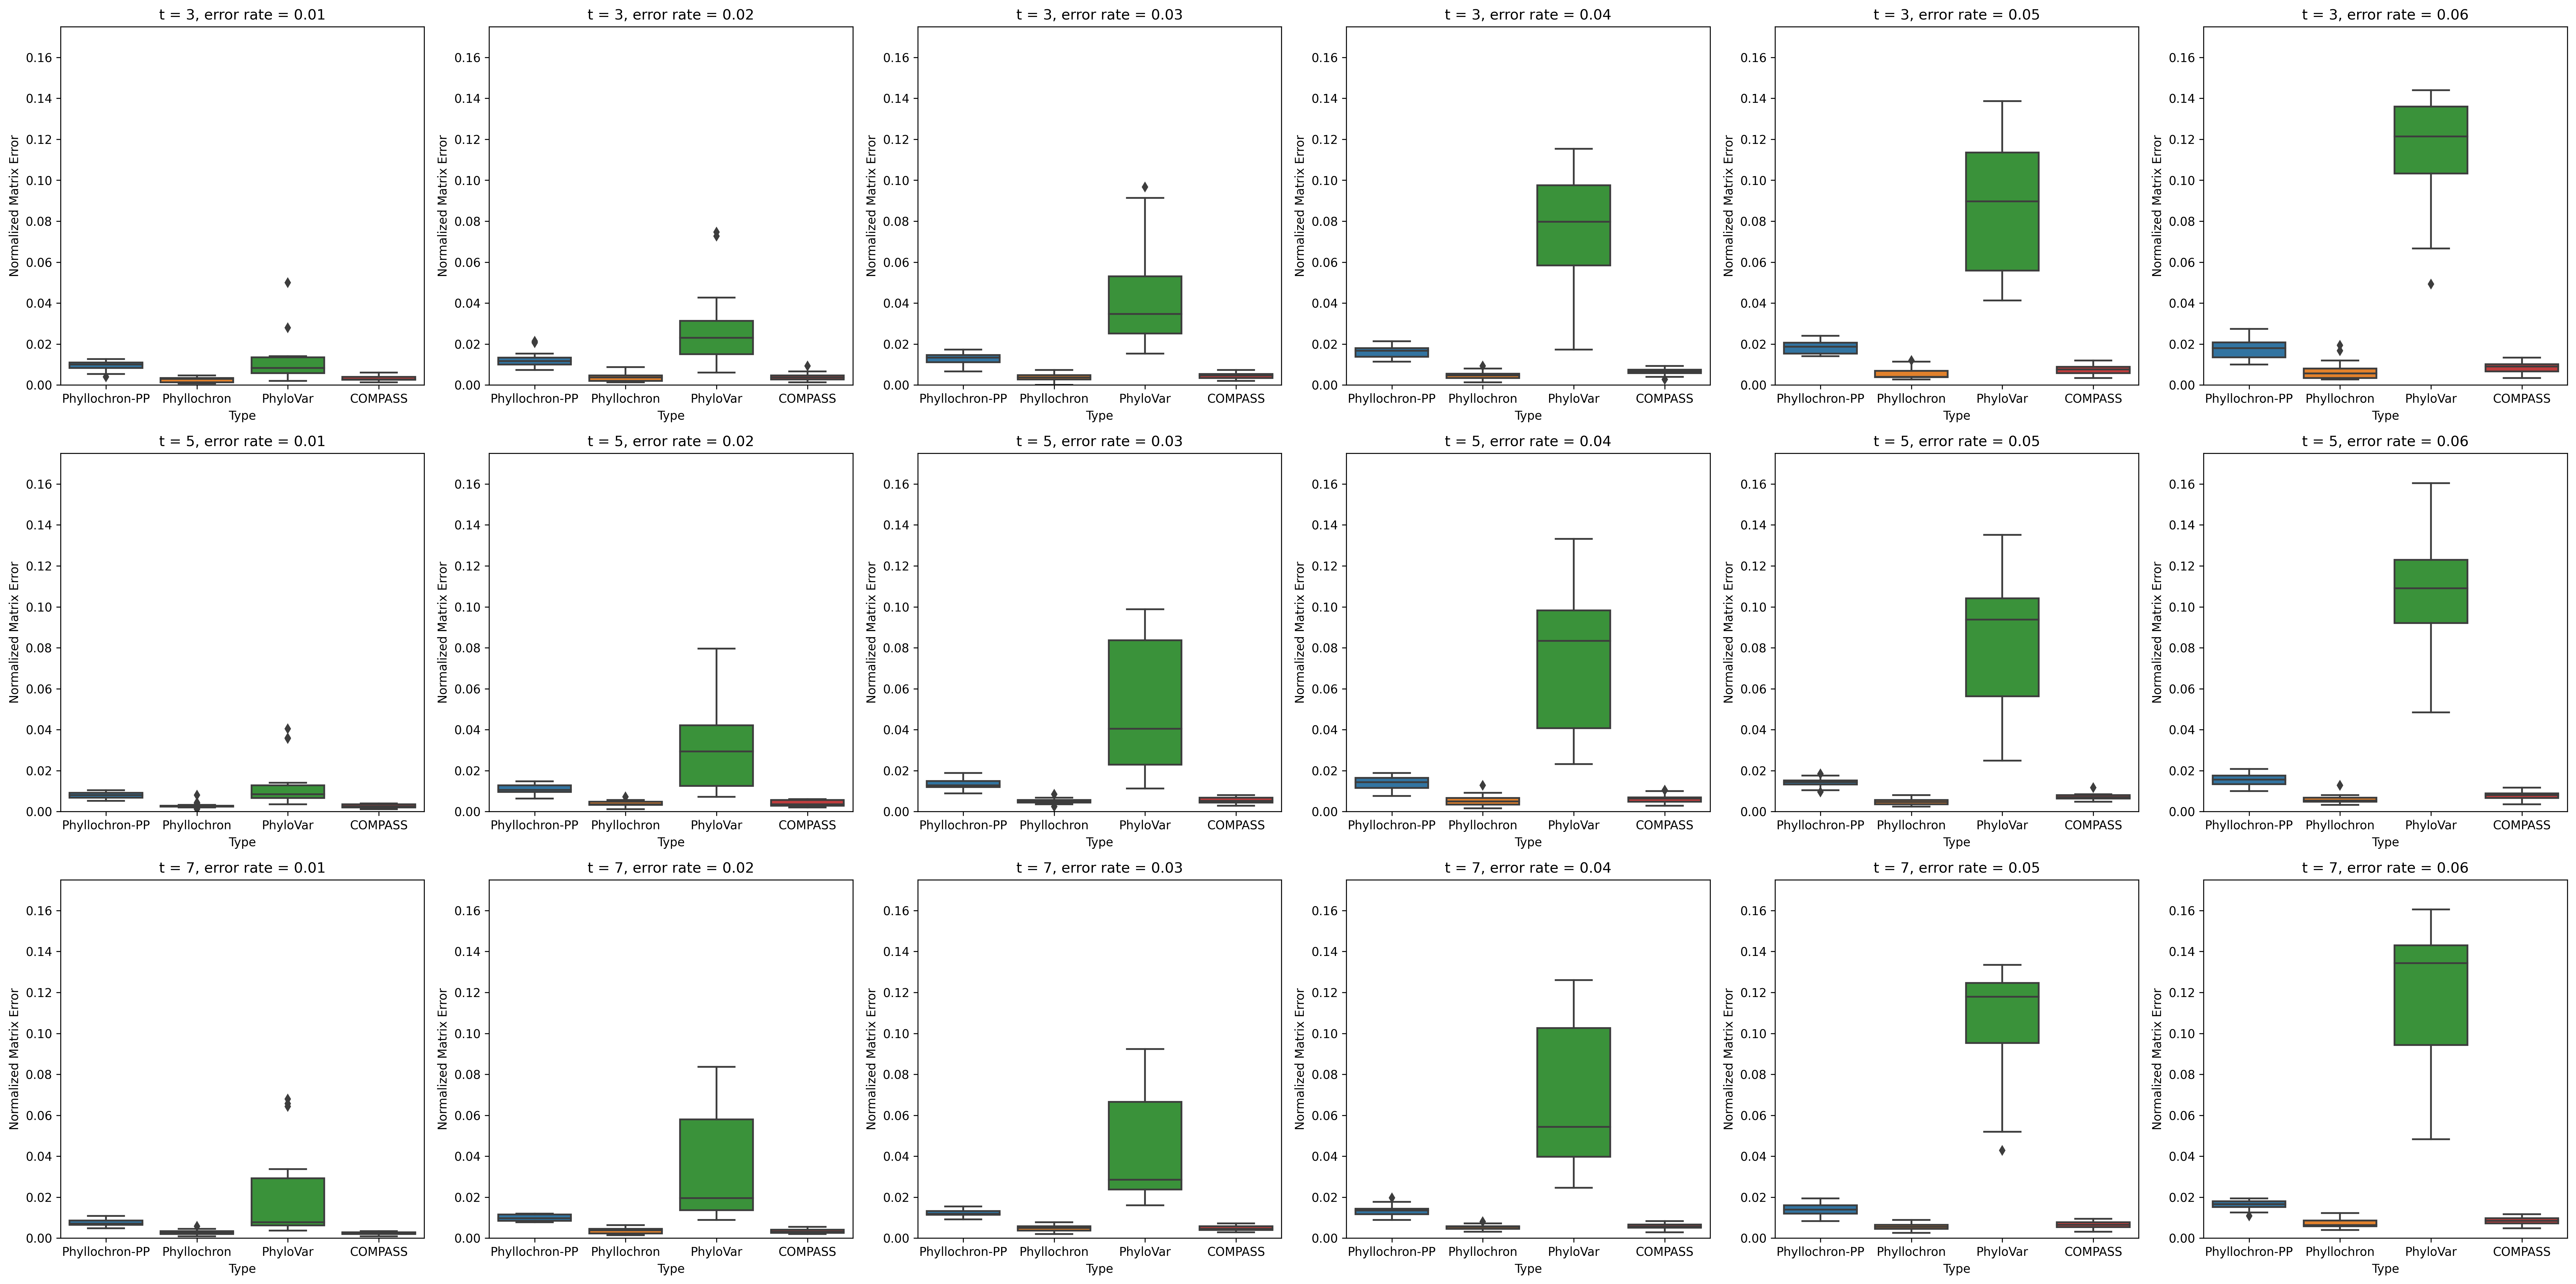

In [261]:
plt.figure()
fig, axs = plt.subplots(len(timepoints), len(error_rates), figsize=(30, 15))
for i, t in enumerate(timepoints):
    for j, prop in enumerate(error_rates):
        phyllochron_pp_diffs = []
        phyllochron_diffs = []
        Phylovar_diffs = []
        COMPASS_diffs = []
        for sd in range(num_replicates + 1):
            if sd < num_replicates:
                og_character_matrix = pd.read_csv(f'../simulations/ground_truth_rc/gt_readcount_{t}_{prop}_{sd}.csv').values[:, 1:]
                phyllochron_df = pd.read_csv(f'../simulations/Phyllochron_RC/phyllochron_{t}_{prop}_{sd}_B.csv')
                phyllochron_pp_df = pd.read_csv(f'../simulations/Phyllochron_PP_RC/phyllochron_pp_{t}_{prop}_{sd}_B.csv')
                Phylovar_df = pd.read_csv(f'../simulations/PhyloVar/phylovar_{t}_{prop}_{sd}/snv.vcf.mat', header=None, sep='\t')
                COMPASS_cell_assignment = pd.read_csv(f'../simulations/COMPASS/compass_{t}_{prop}_{sd}_cellAssignments.tsv', sep='\t')
                COMPASS_genotypes = pd.read_csv(f'../simulations/COMPASS/compass_{t}_{prop}_{sd}_nodes_genotypes.tsv', sep='\t')

                Phylovar_character_matrix = Phylovar_df.values
                COMPASS_character_matrix = build_compass_matrix(COMPASS_cell_assignment, COMPASS_genotypes)
                phyllochron_character_matrix = phyllochron_df.values[:, 1:]
                phyllochron_pp_character_matrix = phyllochron_pp_df.values[:, 1:]
                
                phyllochron_pp_diffs.append(np.sum(np.abs(og_character_matrix - phyllochron_pp_character_matrix))/(ncells_per_sample * nmutations * t))
                phyllochron_diffs.append(np.sum(np.abs(og_character_matrix - phyllochron_character_matrix))/(ncells_per_sample * nmutations * t))
                Phylovar_diffs.append(np.sum(np.abs(og_character_matrix - Phylovar_character_matrix))/(ncells_per_sample * nmutations * t))
                COMPASS_diffs.append(np.sum(np.abs(og_character_matrix - COMPASS_character_matrix))/(ncells_per_sample * nmutations * t))


        data = pd.DataFrame({'Type': num_replicates*['Phyllochron-PP'] + num_replicates*['Phyllochron'] + num_replicates*['PhyloVar'] + num_replicates*['COMPASS'], 'Normalized Matrix Error':phyllochron_pp_diffs + phyllochron_diffs + Phylovar_diffs + COMPASS_diffs})
        axs[i,j].set_ylim(0, 0.175)
        sns.boxplot(x='Type', y='Normalized Matrix Error', data=data, ax = axs[i,j])
        axs[i,j].set_title(f't = {t}, error rate = {prop}')
fig.tight_layout()
plt.show()

### Line Plot

<Figure size 1800x1200 with 0 Axes>

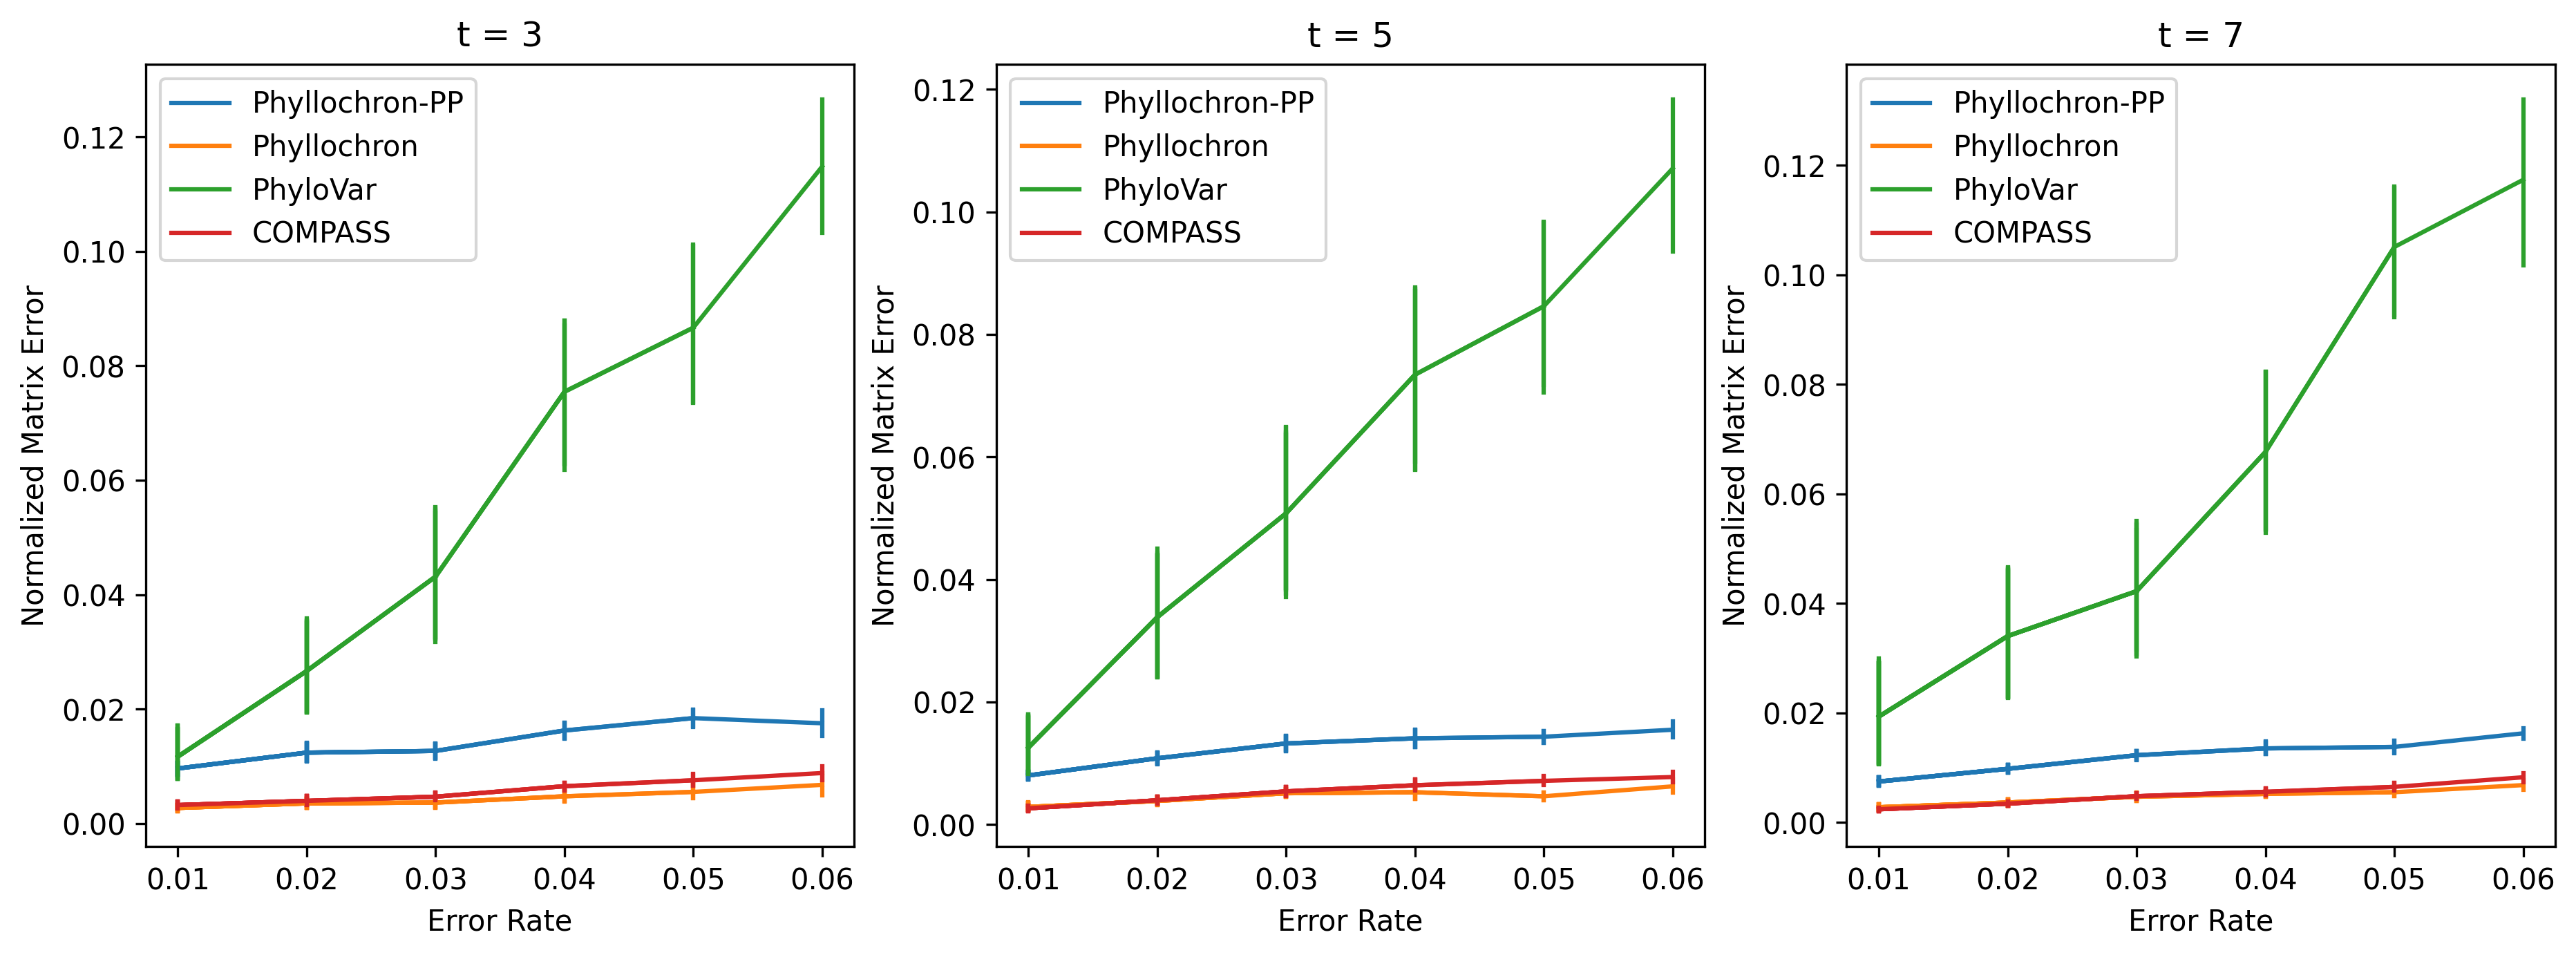

In [234]:
plt.figure()
fig, axs = plt.subplots(1, len(timepoints), figsize=(15, 5))
for i, t in enumerate(timepoints):
    all_data = []
    for j, prop in enumerate(error_rates):
        phyllochron_pp_diffs = []
        phyllochron_diffs = []
        Phylovar_diffs = []
        COMPASS_diffs = []
        for sd in range(num_replicates + 1):
            if sd < num_replicates:
                og_character_matrix = pd.read_csv(f'../simulations/ground_truth_rc/gt_readcount_{t}_{prop}_{sd}.csv').values[:, 1:]
                phyllochron_df = pd.read_csv(f'../simulations/Phyllochron_RC/phyllochron_{t}_{prop}_{sd}_B.csv')
                phyllochron_pp_df = pd.read_csv(f'../simulations/Phyllochron_PP_RC/phyllochron_pp_{t}_{prop}_{sd}_B.csv')
                Phylovar_df = pd.read_csv(f'../simulations/PhyloVar/phylovar_{t}_{prop}_{sd}/snv.vcf.mat', header=None, sep='\t')
                COMPASS_cell_assignment = pd.read_csv(f'../simulations/COMPASS/compass_{t}_{prop}_{sd}_cellAssignments.tsv', sep='\t')
                COMPASS_genotypes = pd.read_csv(f'../simulations/COMPASS/compass_{t}_{prop}_{sd}_nodes_genotypes.tsv', sep='\t')

                Phylovar_character_matrix = Phylovar_df.values
                COMPASS_character_matrix = build_compass_matrix(COMPASS_cell_assignment, COMPASS_genotypes)
                phyllochron_character_matrix = phyllochron_df.values[:, 1:]
                phyllochron_pp_character_matrix = phyllochron_pp_df.values[:, 1:]
                
                phyllochron_pp_diffs.append(np.sum(np.abs(og_character_matrix - phyllochron_pp_character_matrix))/(ncells_per_sample * nmutations * t))
                phyllochron_diffs.append(np.sum(np.abs(og_character_matrix - phyllochron_character_matrix))/(ncells_per_sample * nmutations * t))
                Phylovar_diffs.append(np.sum(np.abs(og_character_matrix - Phylovar_character_matrix))/(ncells_per_sample * nmutations * t))
                COMPASS_diffs.append(np.sum(np.abs(og_character_matrix - COMPASS_character_matrix))/(ncells_per_sample * nmutations * t))



        data = pd.DataFrame({'Error Rate': (4*num_replicates)*[prop],'Type': num_replicates*['Phyllochron-PP'] + num_replicates*['Phyllochron'] + num_replicates*['PhyloVar'] + num_replicates*['COMPASS'], 'Normalized Matrix Error':phyllochron_pp_diffs + phyllochron_diffs + Phylovar_diffs + COMPASS_diffs})
        #axs[i,j].set_ylim(0, 0.20)
        #sns.boxplot(x='Type', y='Normalized Matrix Error', data=data, ax = axs[i,j])
        axs[i].set_title(f't = {t}')
        all_data.append(data)
        data_final= pd.concat(all_data, axis=0, ignore_index=True)
        sns.lineplot(data=data_final, x='Error Rate', y="Normalized Matrix Error", hue="Type", err_style="bars", ax=axs[i])

# Apply function to each subplot
for ax in axs:
    remove_duplicate_legend_entries(ax)

plt.show()

## Plot Phyllochron Likelihood


<Figure size 1800x1200 with 0 Axes>

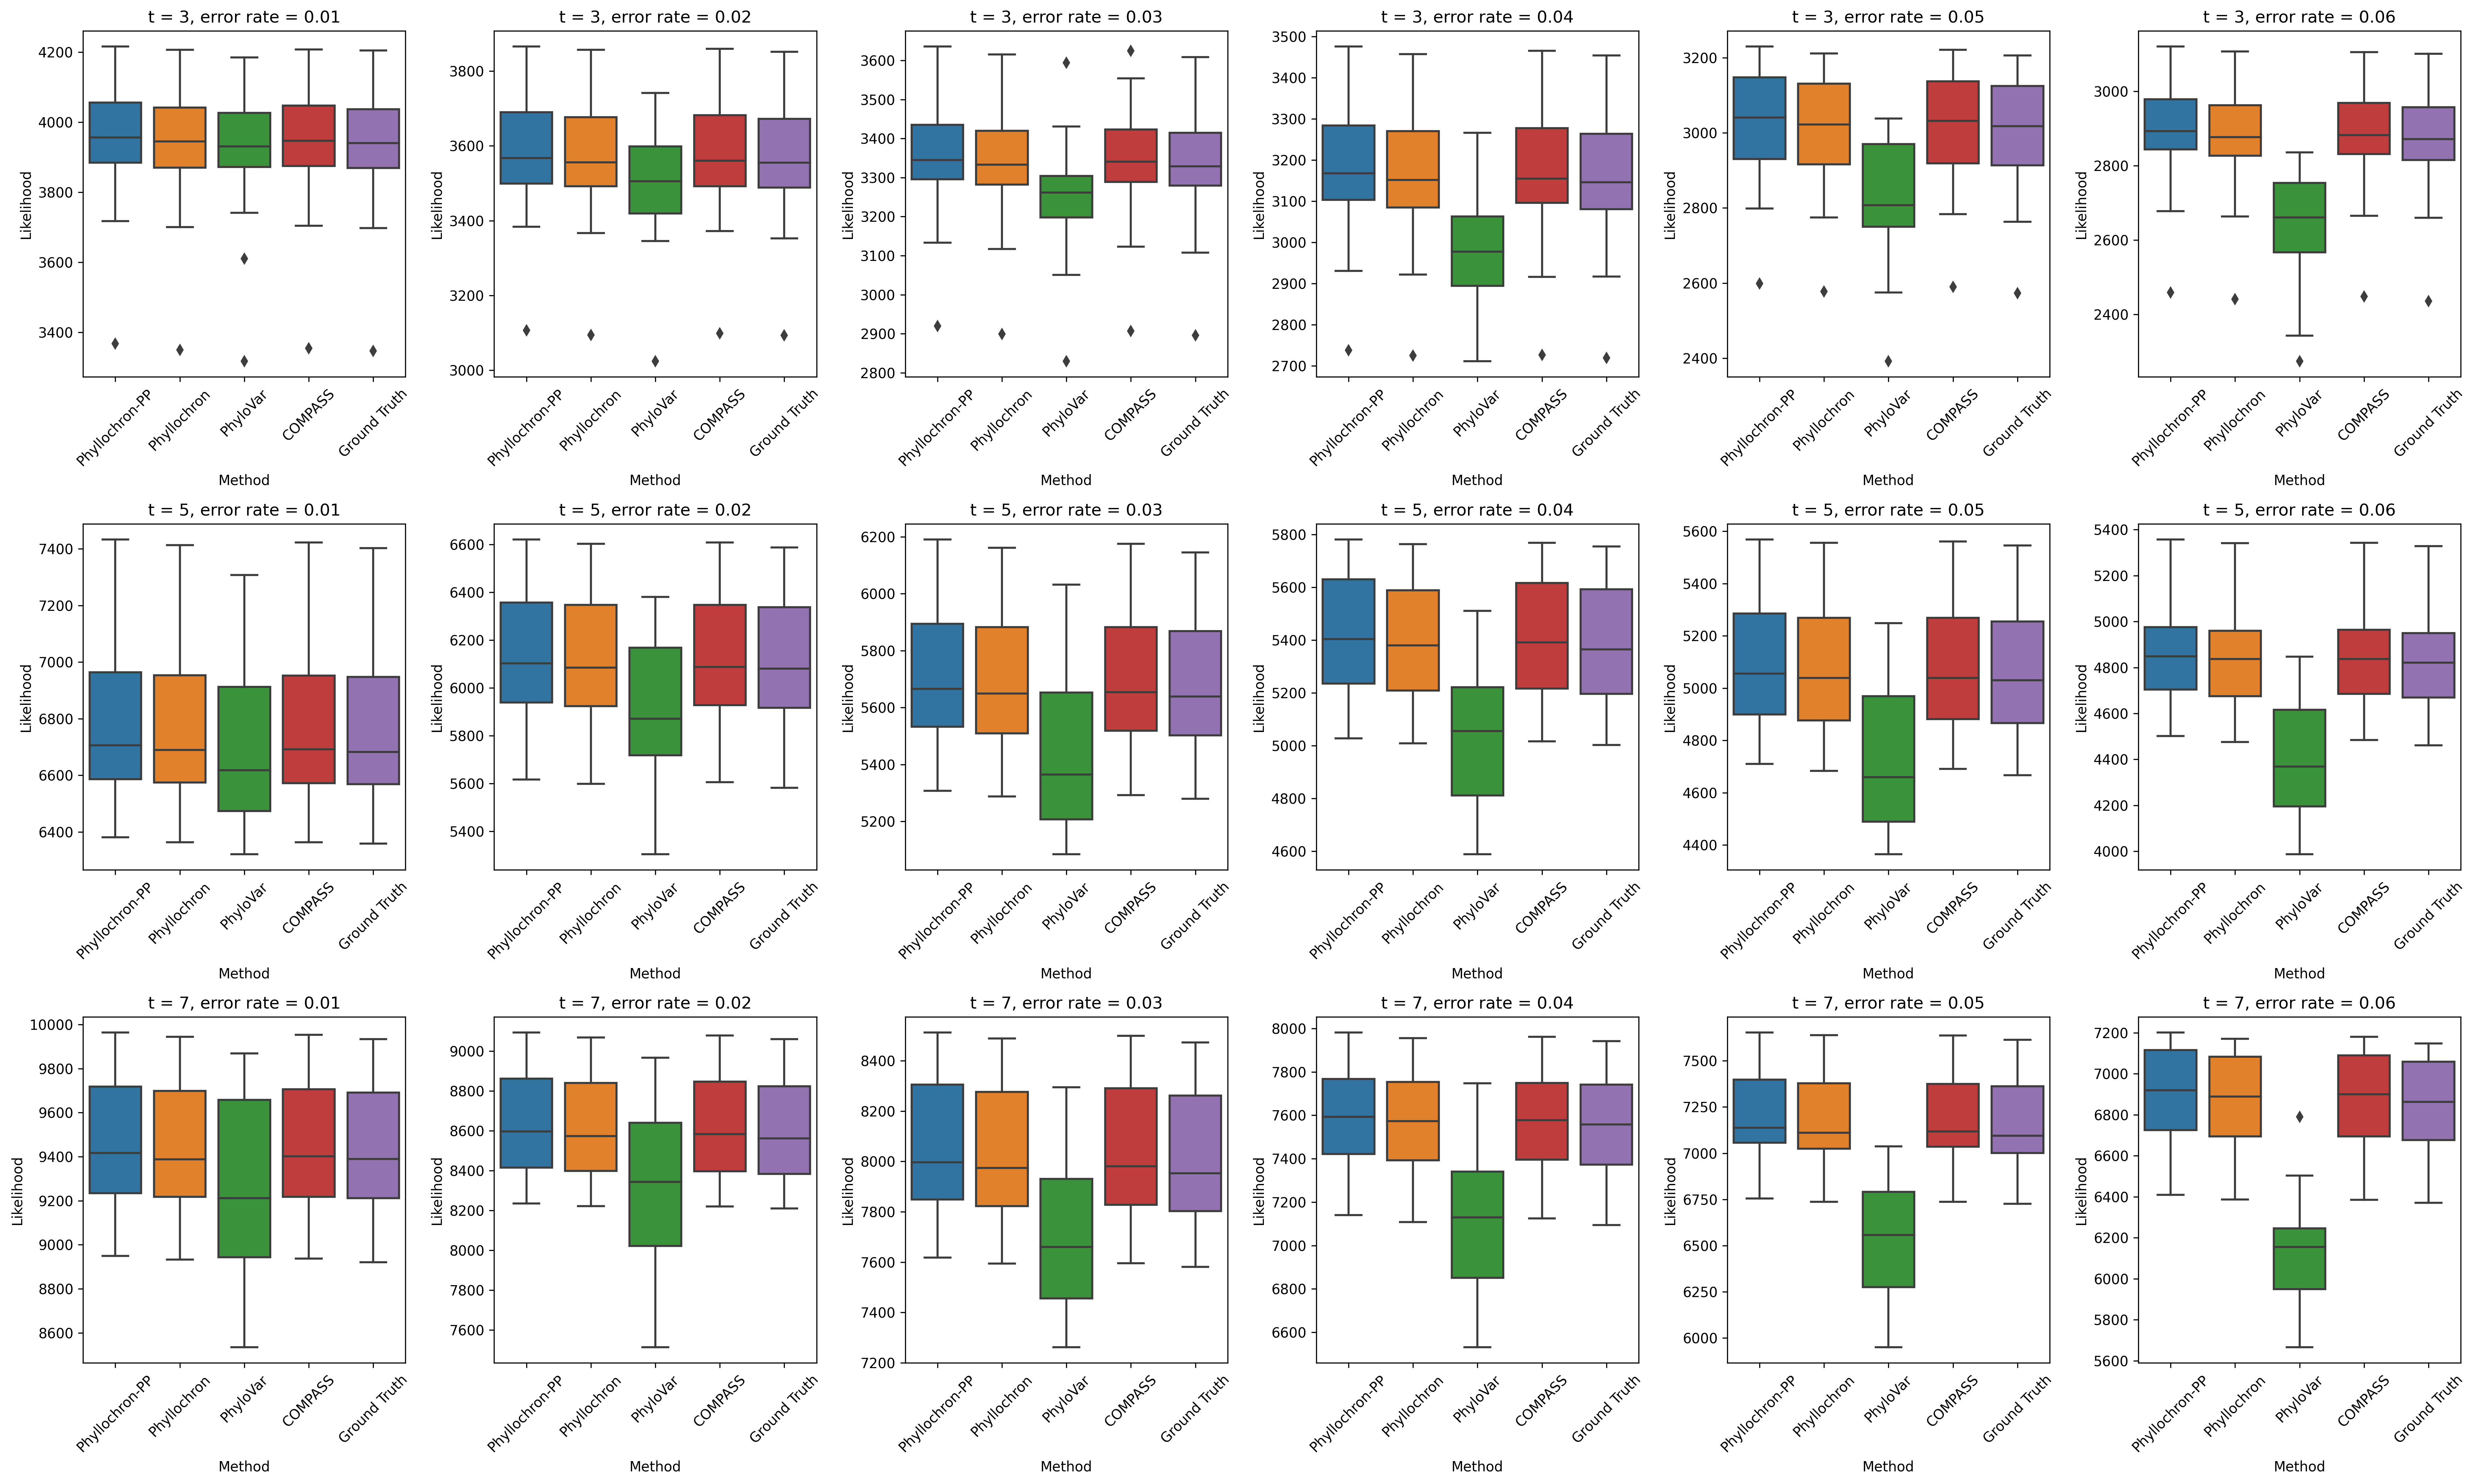

In [263]:
plt.figure()
fig, axs = plt.subplots(len(timepoints), len(error_rates), figsize=(25,15))
for i, t in enumerate(timepoints):
    for j, prop in enumerate(error_rates):
        phyllochron_pp_diffs = []
        phyllochron_diffs = []
        Phylovar_diffs = []
        COMPASS_diffs = []
        og_diffs = []

        for sd in range(num_replicates + 1):
            if sd < num_replicates:
                og_character_matrix = pd.read_csv(f'../simulations/ground_truth_rc/gt_readcount_{t}_{prop}_{sd}.csv').values[:, 1:]
                phyllochron_df = pd.read_csv(f'../simulations/Phyllochron_RC/phyllochron_{t}_{prop}_{sd}_B.csv')
                phyllochron_pp_df = pd.read_csv(f'../simulations/Phyllochron_PP_RC/phyllochron_pp_{t}_{prop}_{sd}_B.csv')
                Phylovar_df = pd.read_csv(f'../simulations/PhyloVar/phylovar_{t}_{prop}_{sd}/snv.vcf.mat', header=None, sep='\t')
                COMPASS_cell_assignment = pd.read_csv(f'../simulations/COMPASS/compass_{t}_{prop}_{sd}_cellAssignments.tsv', sep='\t')
                COMPASS_genotypes = pd.read_csv(f'../simulations/COMPASS/compass_{t}_{prop}_{sd}_nodes_genotypes.tsv', sep='\t')
                df_variant = pd.read_csv(f'../simulations/ground_truth_rc/phyllochron_{t}_{prop}_{sd}_variant_readcounts.csv')
                df_total = pd.read_csv(f'../simulations/ground_truth_rc/phyllochron_{t}_{prop}_{sd}_total_readcounts.csv')
                
                phyllochron_character_matrix = phyllochron_df.values[:, 1:]
                phyllochron_pp_character_matrix = phyllochron_pp_df.values[:, 1:]
                Phylovar_character_matrix = Phylovar_df.values
                COMPASS_character_matrix = build_compass_matrix(COMPASS_cell_assignment, COMPASS_genotypes)
                
                phyllochron_pp_diffs.append(calculate_likelihood_rc(phyllochron_pp_character_matrix,  df_variant.values[:,1:], df_total.values[:,1:], prop))
                phyllochron_diffs.append(calculate_likelihood_rc(phyllochron_character_matrix,  df_variant.values[:,1:], df_total.values[:,1:], prop))
                Phylovar_diffs.append(calculate_likelihood_rc(Phylovar_character_matrix,  df_variant.values[:,1:], df_total.values[:,1:], prop))
                COMPASS_diffs.append(calculate_likelihood_rc(COMPASS_character_matrix,  df_variant.values[:,1:], df_total.values[:,1:], prop))
                og_diffs.append(calculate_likelihood_rc(og_character_matrix,  df_variant.values[:,1:], df_total.values[:,1:], prop))
                if phyllochron_pp_diffs[-1] < phyllochron_diffs[-1]:
                    print(t, prop, phyllochron_pp_diffs[-1],  phyllochron_diffs[-1])
                

        data = pd.DataFrame({'Method': num_replicates*['Phyllochron-PP'] + num_replicates*['Phyllochron'] + num_replicates*['PhyloVar'] + num_replicates*['COMPASS'] + num_replicates*['Ground Truth'], 'Likelihood':phyllochron_pp_diffs + phyllochron_diffs + Phylovar_diffs + COMPASS_diffs + og_diffs})
        axs[i,j].tick_params(axis='x', labelrotation=45)
        #axs[i,j].set_ylim(12000, 110000)
        sns.boxplot(x='Method', y='Likelihood', data=data, ax = axs[i,j])
        axs[i,j].set_title(f't = {t}, error rate = {prop}')
fig.tight_layout()
plt.show()

## Plot COMPASS Likelihood


<Figure size 1800x1200 with 0 Axes>

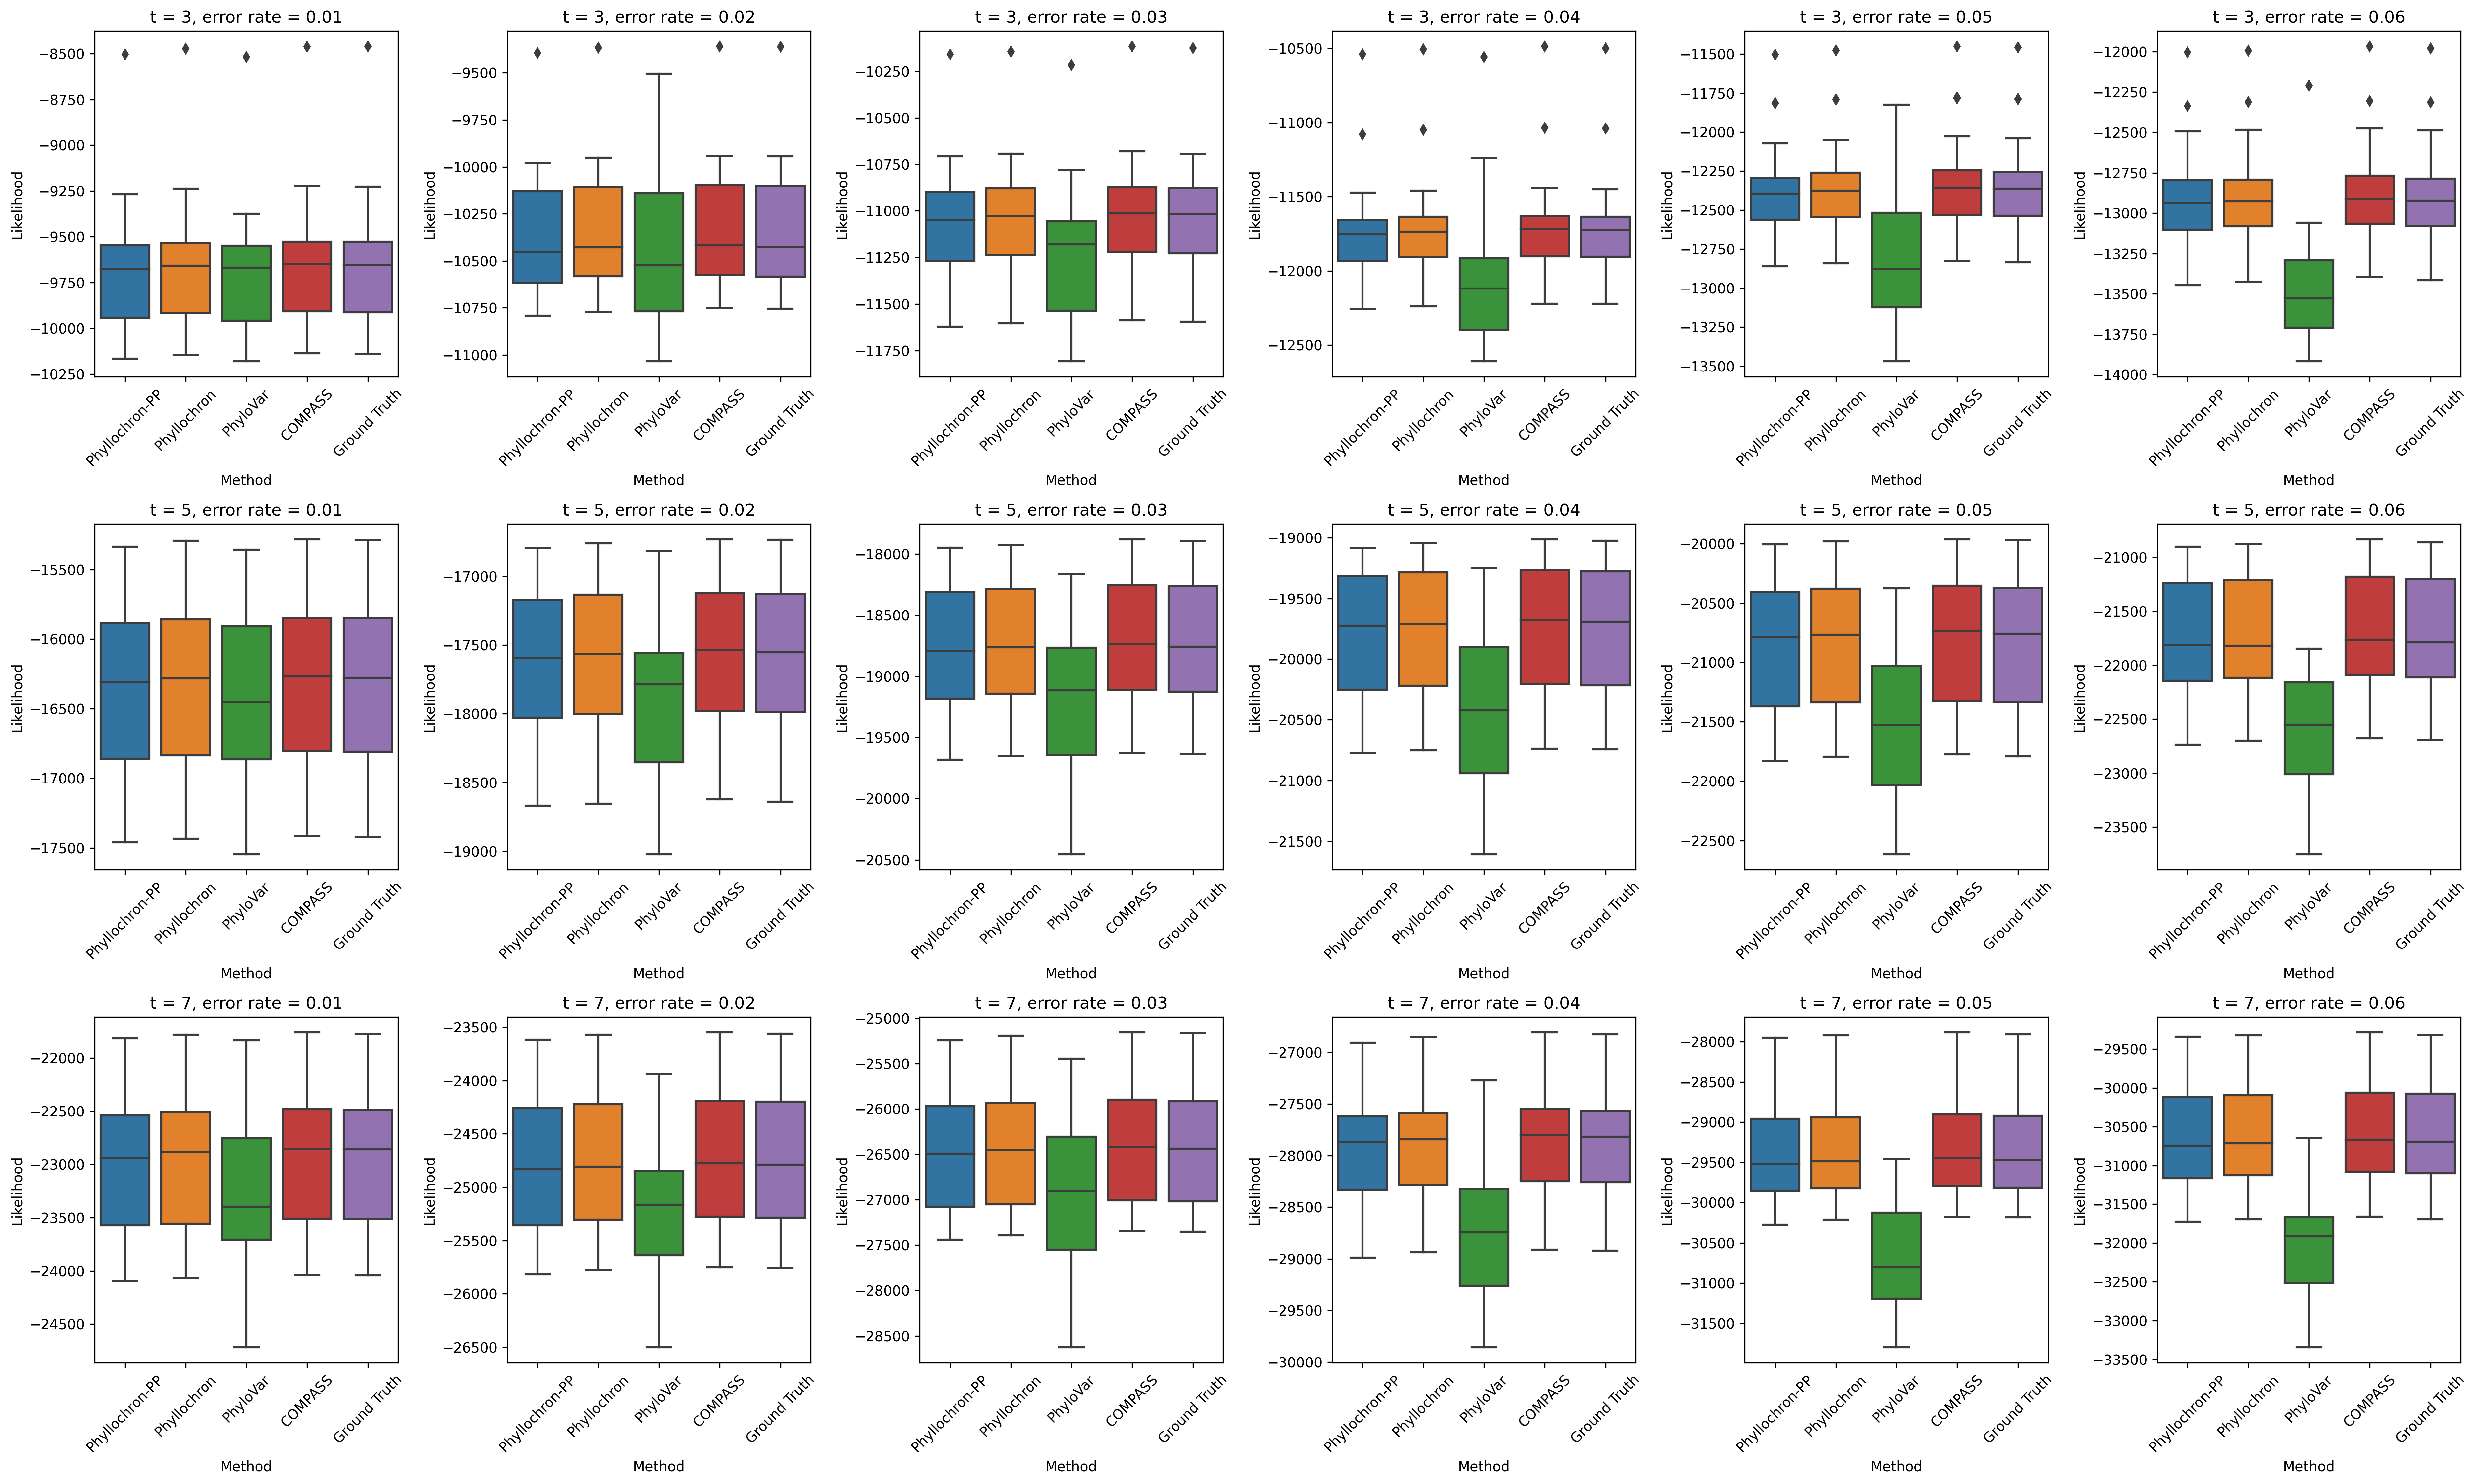

In [264]:
plt.figure()
fig, axs = plt.subplots(len(timepoints), len(error_rates), figsize=(25, 15))
for i, t in enumerate(timepoints):
    for j, prop in enumerate(error_rates):
        phyllochron_pp_diffs = []
        phyllochron_diffs = []
        Phylovar_diffs = []
        COMPASS_diffs = []
        og_diffs = []

        for sd in range(num_replicates + 1):
            if sd < num_replicates:
                og_character_matrix = pd.read_csv(f'../simulations/ground_truth_rc/gt_readcount_{t}_{prop}_{sd}.csv').values[:, 1:]
                phyllochron_df = pd.read_csv(f'../simulations/Phyllochron_RC/phyllochron_{t}_{prop}_{sd}_B.csv')
                phyllochron_pp_df = pd.read_csv(f'../simulations/Phyllochron_PP_RC/phyllochron_pp_{t}_{prop}_{sd}_B.csv')
                Phylovar_df = pd.read_csv(f'../simulations/PhyloVar/phylovar_{t}_{prop}_{sd}/snv.vcf.mat', header=None, sep='\t')
                COMPASS_cell_assignment = pd.read_csv(f'../simulations/COMPASS/compass_{t}_{prop}_{sd}_cellAssignments.tsv', sep='\t')
                COMPASS_genotypes = pd.read_csv(f'../simulations/COMPASS/compass_{t}_{prop}_{sd}_nodes_genotypes.tsv', sep='\t')
                df_variant = pd.read_csv(f'../simulations/ground_truth_rc/phyllochron_{t}_{prop}_{sd}_variant_readcounts.csv')
                df_total = pd.read_csv(f'../simulations/ground_truth_rc/phyllochron_{t}_{prop}_{sd}_total_readcounts.csv')
                
                phyllochron_character_matrix = phyllochron_df.values[:, 1:]
                phyllochron_pp_character_matrix = phyllochron_pp_df.values[:, 1:]
                Phylovar_character_matrix = Phylovar_df.values
                COMPASS_character_matrix = build_compass_matrix(COMPASS_cell_assignment, COMPASS_genotypes)
                
                phyllochron_pp_diffs.append(calculate_likelihood_COMPASS(phyllochron_pp_character_matrix,  df_variant.values[:,1:], df_total.values[:,1:], prop))
                phyllochron_diffs.append(calculate_likelihood_COMPASS(phyllochron_character_matrix,  df_variant.values[:,1:], df_total.values[:,1:], prop))
                Phylovar_diffs.append(calculate_likelihood_COMPASS(Phylovar_character_matrix,  df_variant.values[:,1:], df_total.values[:,1:], prop))
                COMPASS_diffs.append(calculate_likelihood_COMPASS(COMPASS_character_matrix,  df_variant.values[:,1:], df_total.values[:,1:], prop))
                og_diffs.append(calculate_likelihood_COMPASS(og_character_matrix,  df_variant.values[:,1:], df_total.values[:,1:], prop))

                if COMPASS_diffs[-1] < phyllochron_diffs[-1]:
                    print(t, prop, COMPASS_diffs[-1],  phyllochron_diffs[-1])
                

        data = pd.DataFrame({'Method': num_replicates*['Phyllochron-PP'] + num_replicates*['Phyllochron'] + num_replicates*['PhyloVar'] + num_replicates*['COMPASS'] + num_replicates*['Ground Truth'], 'Likelihood':phyllochron_pp_diffs + phyllochron_diffs + Phylovar_diffs + COMPASS_diffs + og_diffs})
        axs[i,j].tick_params(axis='x', labelrotation=45)
        #axs[i,j].set_ylim(12000, 110000)
        sns.boxplot(x='Method', y='Likelihood', data=data, ax = axs[i,j])
        axs[i,j].set_title(f't = {t}, error rate = {prop}')
fig.tight_layout()
plt.show()

## Plot Clonal Lifespan Accuracy

### Box Plot

<Figure size 1800x1200 with 0 Axes>

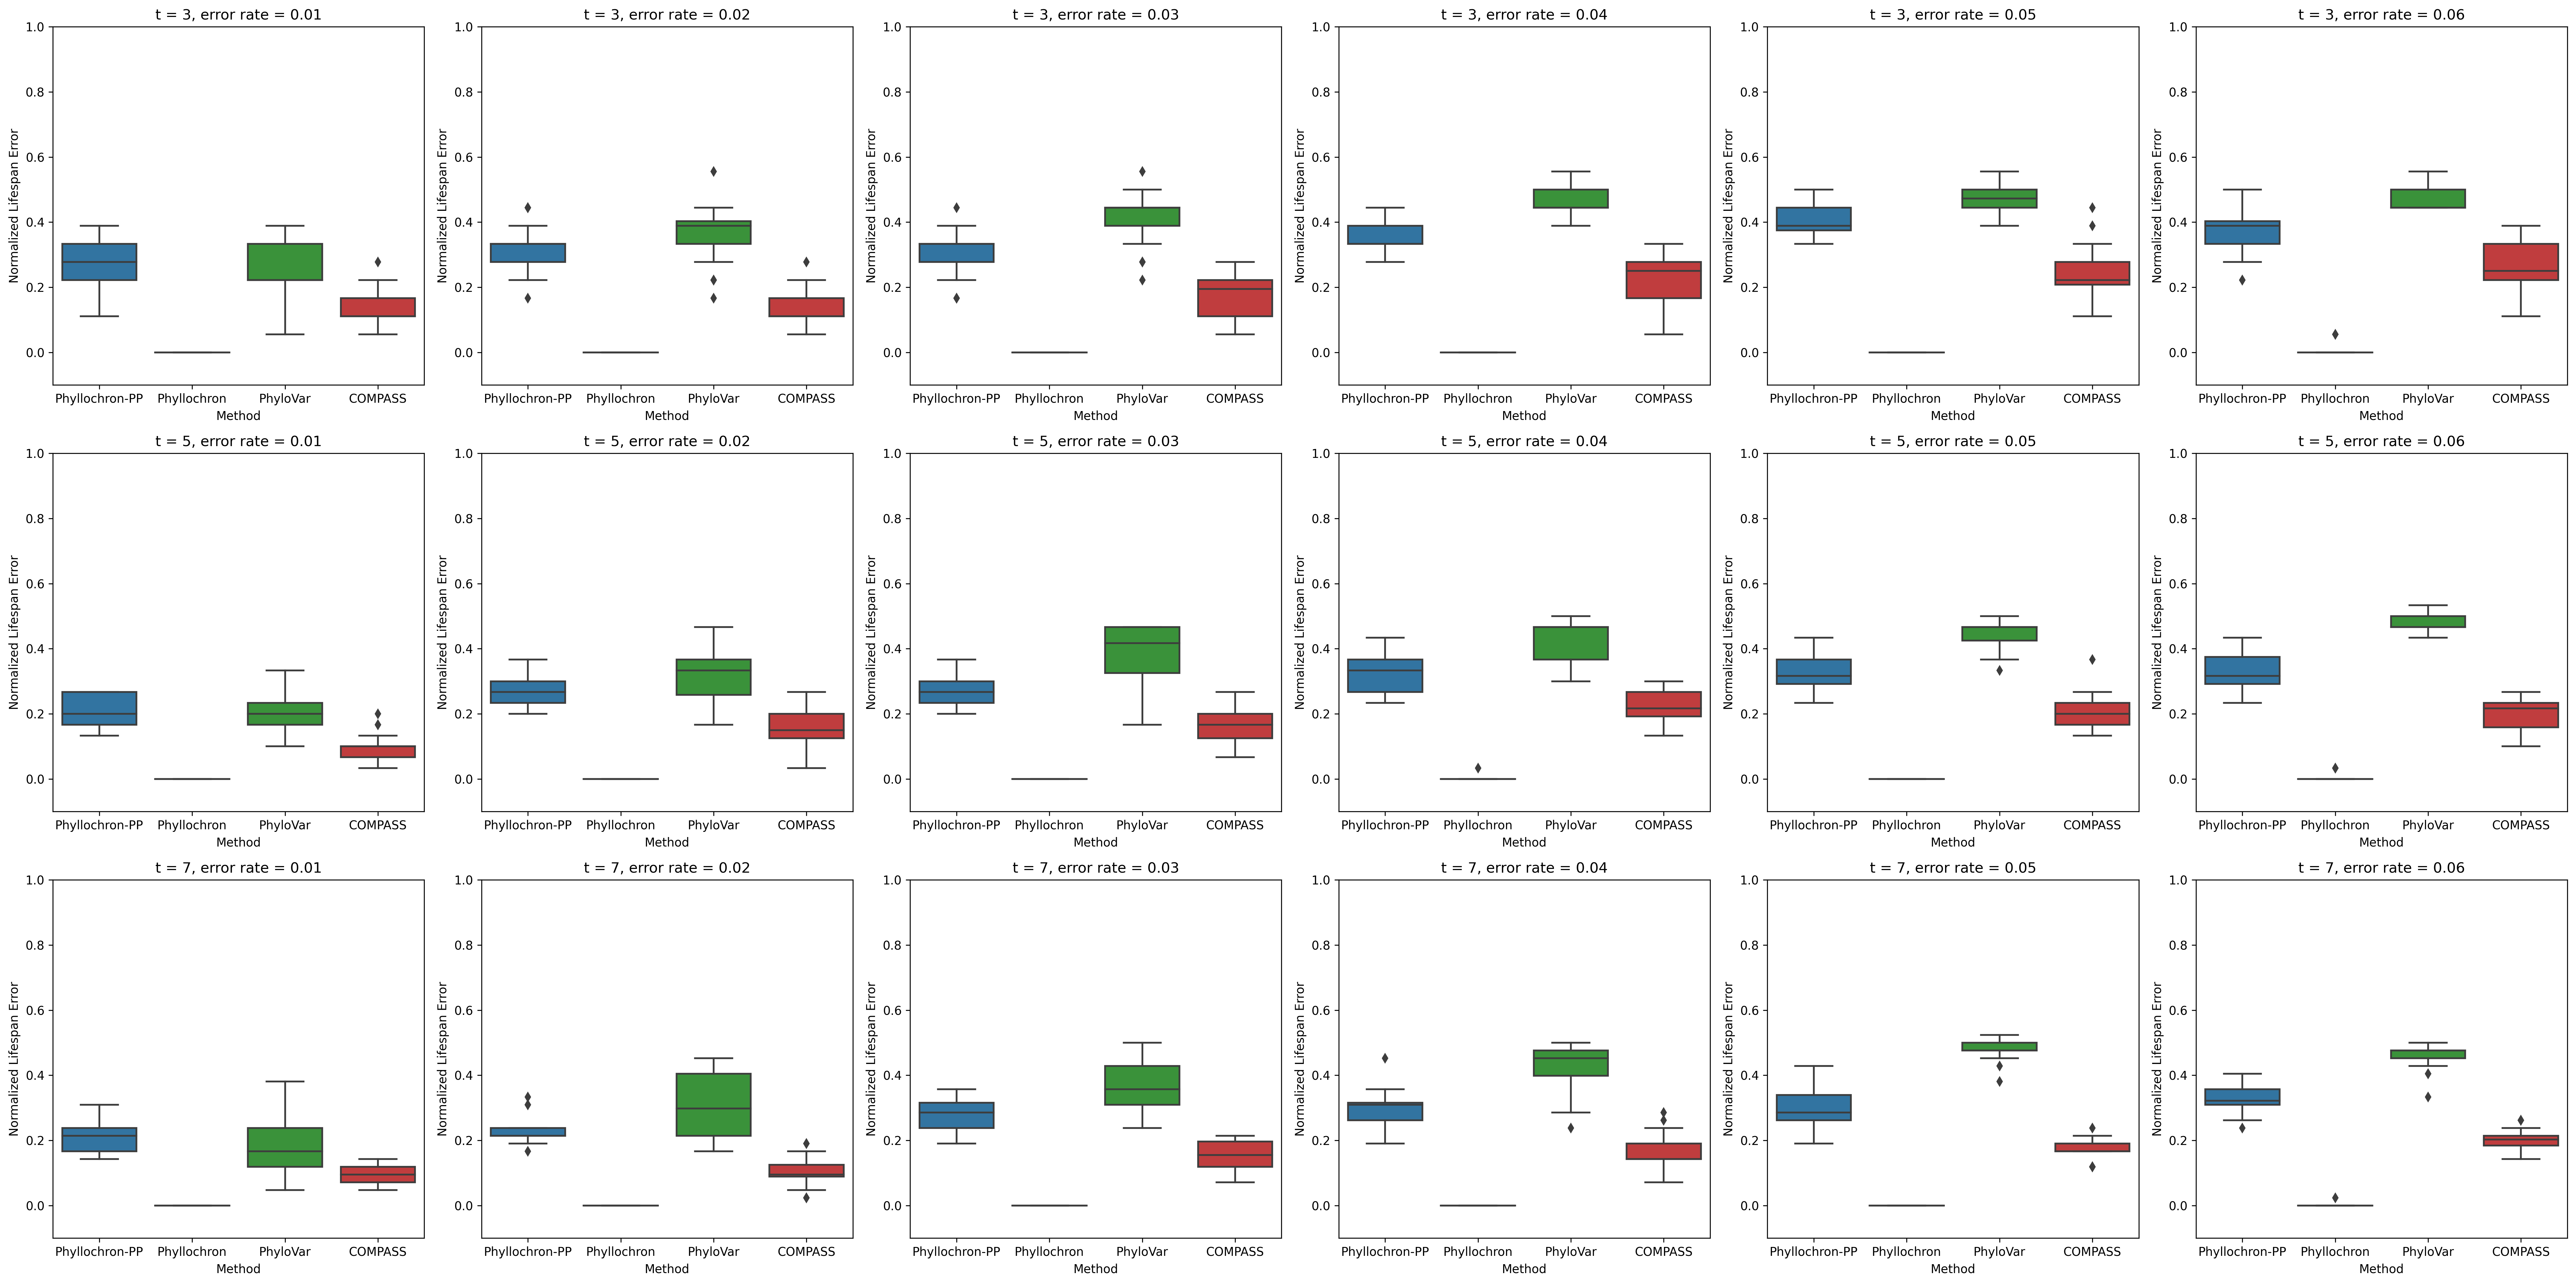

In [267]:
plt.figure()
fig, axs = plt.subplots(len(timepoints), len(error_rates), figsize=(30, 15))
for i, t in enumerate(timepoints):
    for j, prop in enumerate(error_rates):
        phyllochron_pp_diffs = []
        phyllochron_diffs = []
        Phylovar_diffs = []
        COMPASS_diffs = []
        for sd in range(num_replicates + 1):
            if sd < num_replicates:
                og_character_matrix = pd.read_csv(f'../simulations/ground_truth_rc/gt_readcount_{t}_{prop}_{sd}.csv').values[:, 1:]
                original_map = defaultdict(set)
                timepoint_count = defaultdict()
                for r in range(og_character_matrix.shape[0]):
                    if " ".join(map(str, map(int, og_character_matrix[r]))) not in timepoint_count.keys():
                        timepoint_count[" ".join(map(str, map(int, og_character_matrix[r])))] = defaultdict(int)
                    timepoint_count[" ".join(map(str, map(int, og_character_matrix[r])))][r//ncells_per_sample] += 1
                    if timepoint_count[" ".join(map(str, map(int, og_character_matrix[r])))][r//ncells_per_sample] >= 0:
                        original_map[" ".join(map(str, map(int, og_character_matrix[r])))].add(r//ncells_per_sample)

                phyllochron_df = pd.read_csv(f'../simulations/Phyllochron_RC/phyllochron_{t}_{prop}_{sd}_B.csv')
                phyllochron_pp_df = pd.read_csv(f'../simulations/Phyllochron_PP_RC/phyllochron_pp_{t}_{prop}_{sd}_B.csv')
                Phylovar_df = pd.read_csv(f'../simulations/PhyloVar/phylovar_{t}_{prop}_{sd}/snv.vcf.mat', header=None, sep='\t')
                COMPASS_cell_assignment = pd.read_csv(f'../simulations/COMPASS/compass_{t}_{prop}_{sd}_cellAssignments.tsv', sep='\t')
                COMPASS_genotypes = pd.read_csv(f'../simulations/COMPASS/compass_{t}_{prop}_{sd}_nodes_genotypes.tsv', sep='\t')
    
                
                phyllochron_character_matrix = phyllochron_df.values[:, 1:]
                phyllochron_pp_character_matrix = phyllochron_pp_df.values[:, 1:]
                Phylovar_character_matrix = Phylovar_df.values
                COMPASS_character_matrix = build_compass_matrix(COMPASS_cell_assignment, COMPASS_genotypes)
                
                phyllochron_pp_diffs.append(clonal_accuracy(original_map, phyllochron_pp_character_matrix, ncells_per_sample, opt=20)/((nmutations + 1) * t))
                phyllochron_diffs.append(clonal_accuracy(original_map , phyllochron_character_matrix, ncells_per_sample,opt=20)/((nmutations + 1) * t))
                Phylovar_diffs.append(clonal_accuracy(original_map , Phylovar_character_matrix, ncells_per_sample,  opt=20)/((nmutations + 1) * t))
                COMPASS_diffs.append(clonal_accuracy(original_map , COMPASS_character_matrix, ncells_per_sample, opt=20)/((nmutations + 1) * t))

        data = pd.DataFrame({'Method': num_replicates*['Phyllochron-PP'] + num_replicates*['Phyllochron'] + num_replicates*['PhyloVar'] + num_replicates*['COMPASS'],'Normalized Lifespan Error':phyllochron_pp_diffs + phyllochron_diffs + Phylovar_diffs + COMPASS_diffs})
        axs[i,j].set_ylim(-0.1, 1.00)
        sns.boxplot(x='Method', y='Normalized Lifespan Error', data=data, ax = axs[i,j])
        axs[i,j].set_title(f't = {t}, error rate = {prop}')
fig.tight_layout()
plt.show()

<Figure size 1800x1200 with 0 Axes>

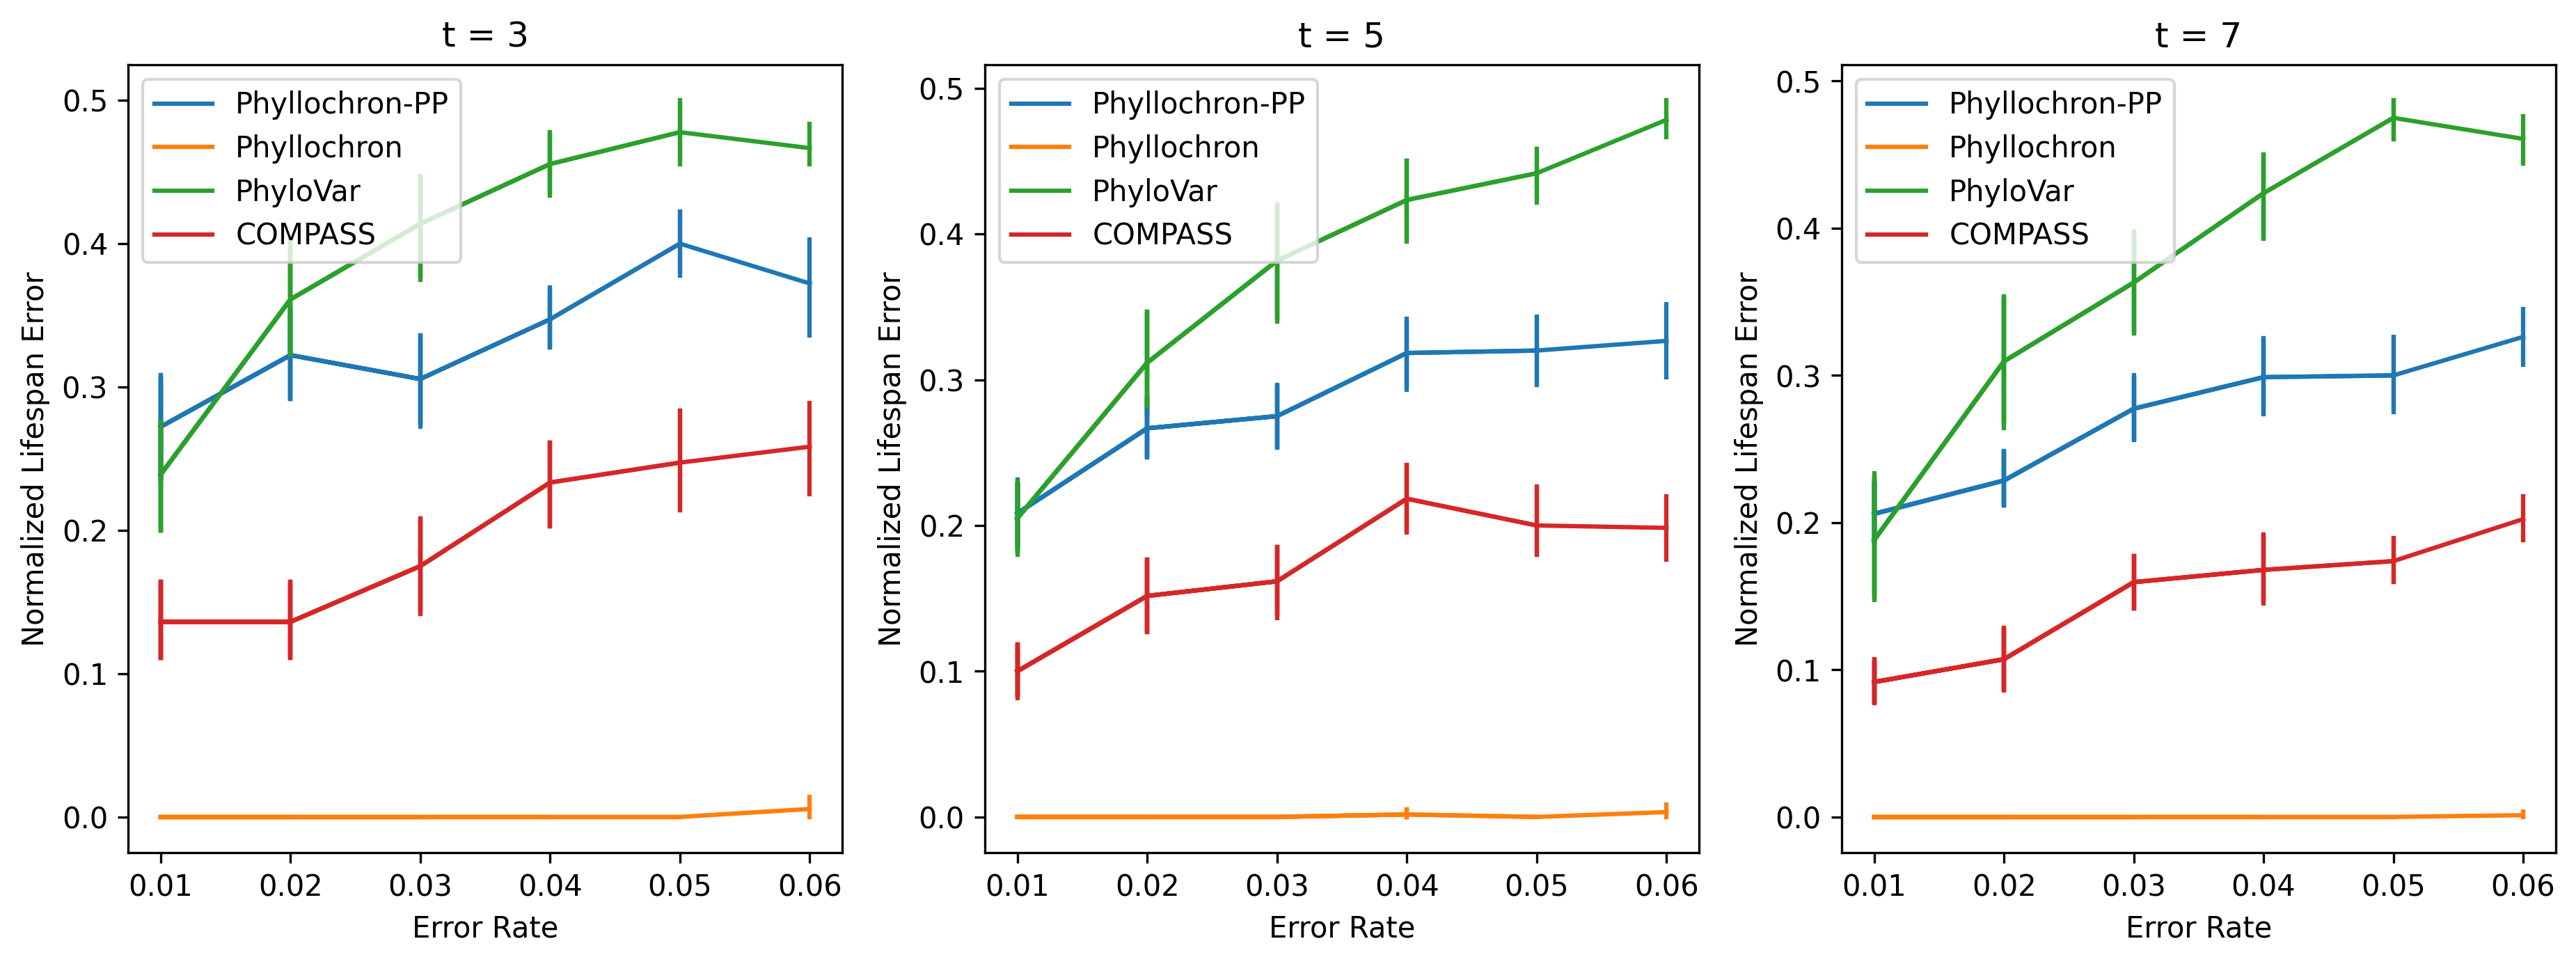

In [238]:
plt.figure()
fig, axs = plt.subplots(1, len(timepoints), figsize=(15, 5))
for i, t in enumerate(timepoints):
    all_data = []
    for j, prop in enumerate(error_rates):
        phyllochron_pp_diffs = []
        phyllochron_diffs = []
        Phylovar_diffs = []
        COMPASS_diffs = []
        for sd in range(num_replicates + 1):
            if sd < num_replicates:
                og_character_matrix = pd.read_csv(f'../simulations/ground_truth_rc/gt_readcount_{t}_{prop}_{sd}.csv').values[:, 1:]
                original_map = defaultdict(set)
                timepoint_count = defaultdict()
                for r in range(og_character_matrix.shape[0]):
                    if " ".join(map(str, map(int, og_character_matrix[r]))) not in timepoint_count.keys():
                        timepoint_count[" ".join(map(str, map(int, og_character_matrix[r])))] = defaultdict(int)
                    timepoint_count[" ".join(map(str, map(int, og_character_matrix[r])))][r//ncells_per_sample] += 1
                    if timepoint_count[" ".join(map(str, map(int, og_character_matrix[r])))][r//ncells_per_sample] >= 0:
                        original_map[" ".join(map(str, map(int, og_character_matrix[r])))].add(r//ncells_per_sample)

                phyllochron_df = pd.read_csv(f'../simulations/Phyllochron_RC/phyllochron_{t}_{prop}_{sd}_B.csv')
                phyllochron_pp_df = pd.read_csv(f'../simulations/Phyllochron_PP_RC/phyllochron_pp_{t}_{prop}_{sd}_B.csv')
                Phylovar_df = pd.read_csv(f'../simulations/PhyloVar/phylovar_{t}_{prop}_{sd}/snv.vcf.mat', header=None, sep='\t')
                COMPASS_cell_assignment = pd.read_csv(f'../simulations/COMPASS/compass_{t}_{prop}_{sd}_cellAssignments.tsv', sep='\t')
                COMPASS_genotypes = pd.read_csv(f'../simulations/COMPASS/compass_{t}_{prop}_{sd}_nodes_genotypes.tsv', sep='\t')
    
                
                phyllochron_character_matrix = phyllochron_df.values[:, 1:]
                phyllochron_pp_character_matrix = phyllochron_pp_df.values[:, 1:]
                Phylovar_character_matrix = Phylovar_df.values
                COMPASS_character_matrix = build_compass_matrix(COMPASS_cell_assignment, COMPASS_genotypes)
                
                phyllochron_pp_diffs.append(clonal_accuracy(original_map, phyllochron_pp_character_matrix, ncells_per_sample, opt=20)/((nmutations + 1) * t))
                phyllochron_diffs.append(clonal_accuracy(original_map , phyllochron_character_matrix, ncells_per_sample,opt=20)/((nmutations + 1) * t))
                Phylovar_diffs.append(clonal_accuracy(original_map , Phylovar_character_matrix, ncells_per_sample,  opt=20)/((nmutations + 1) * t))
                COMPASS_diffs.append(clonal_accuracy(original_map , COMPASS_character_matrix, ncells_per_sample, opt=20)/((nmutations + 1) * t))



        data = pd.DataFrame({'Error Rate': (4*num_replicates)*[prop],'Type': num_replicates*['Phyllochron-PP'] + num_replicates*['Phyllochron'] + num_replicates*['PhyloVar'] + num_replicates*['COMPASS'],'Normalized Lifespan Error':phyllochron_pp_diffs + phyllochron_diffs + Phylovar_diffs + COMPASS_diffs})

        axs[i].set_title(f't = {t}')
        #axs[i].set_ylim(-0.1, 1.00)
        all_data.append(data)
        data_final= pd.concat(all_data, axis=0, ignore_index=True)
        sns.lineplot(data=data_final, x='Error Rate', y="Normalized Lifespan Error", hue="Type", err_style ="bars", ax=axs[i])

# Apply function to each subplot
for ax in axs:
    remove_duplicate_legend_entries(ax)

plt.show()

## Plot Tree Accuracy

<Figure size 1800x1200 with 0 Axes>

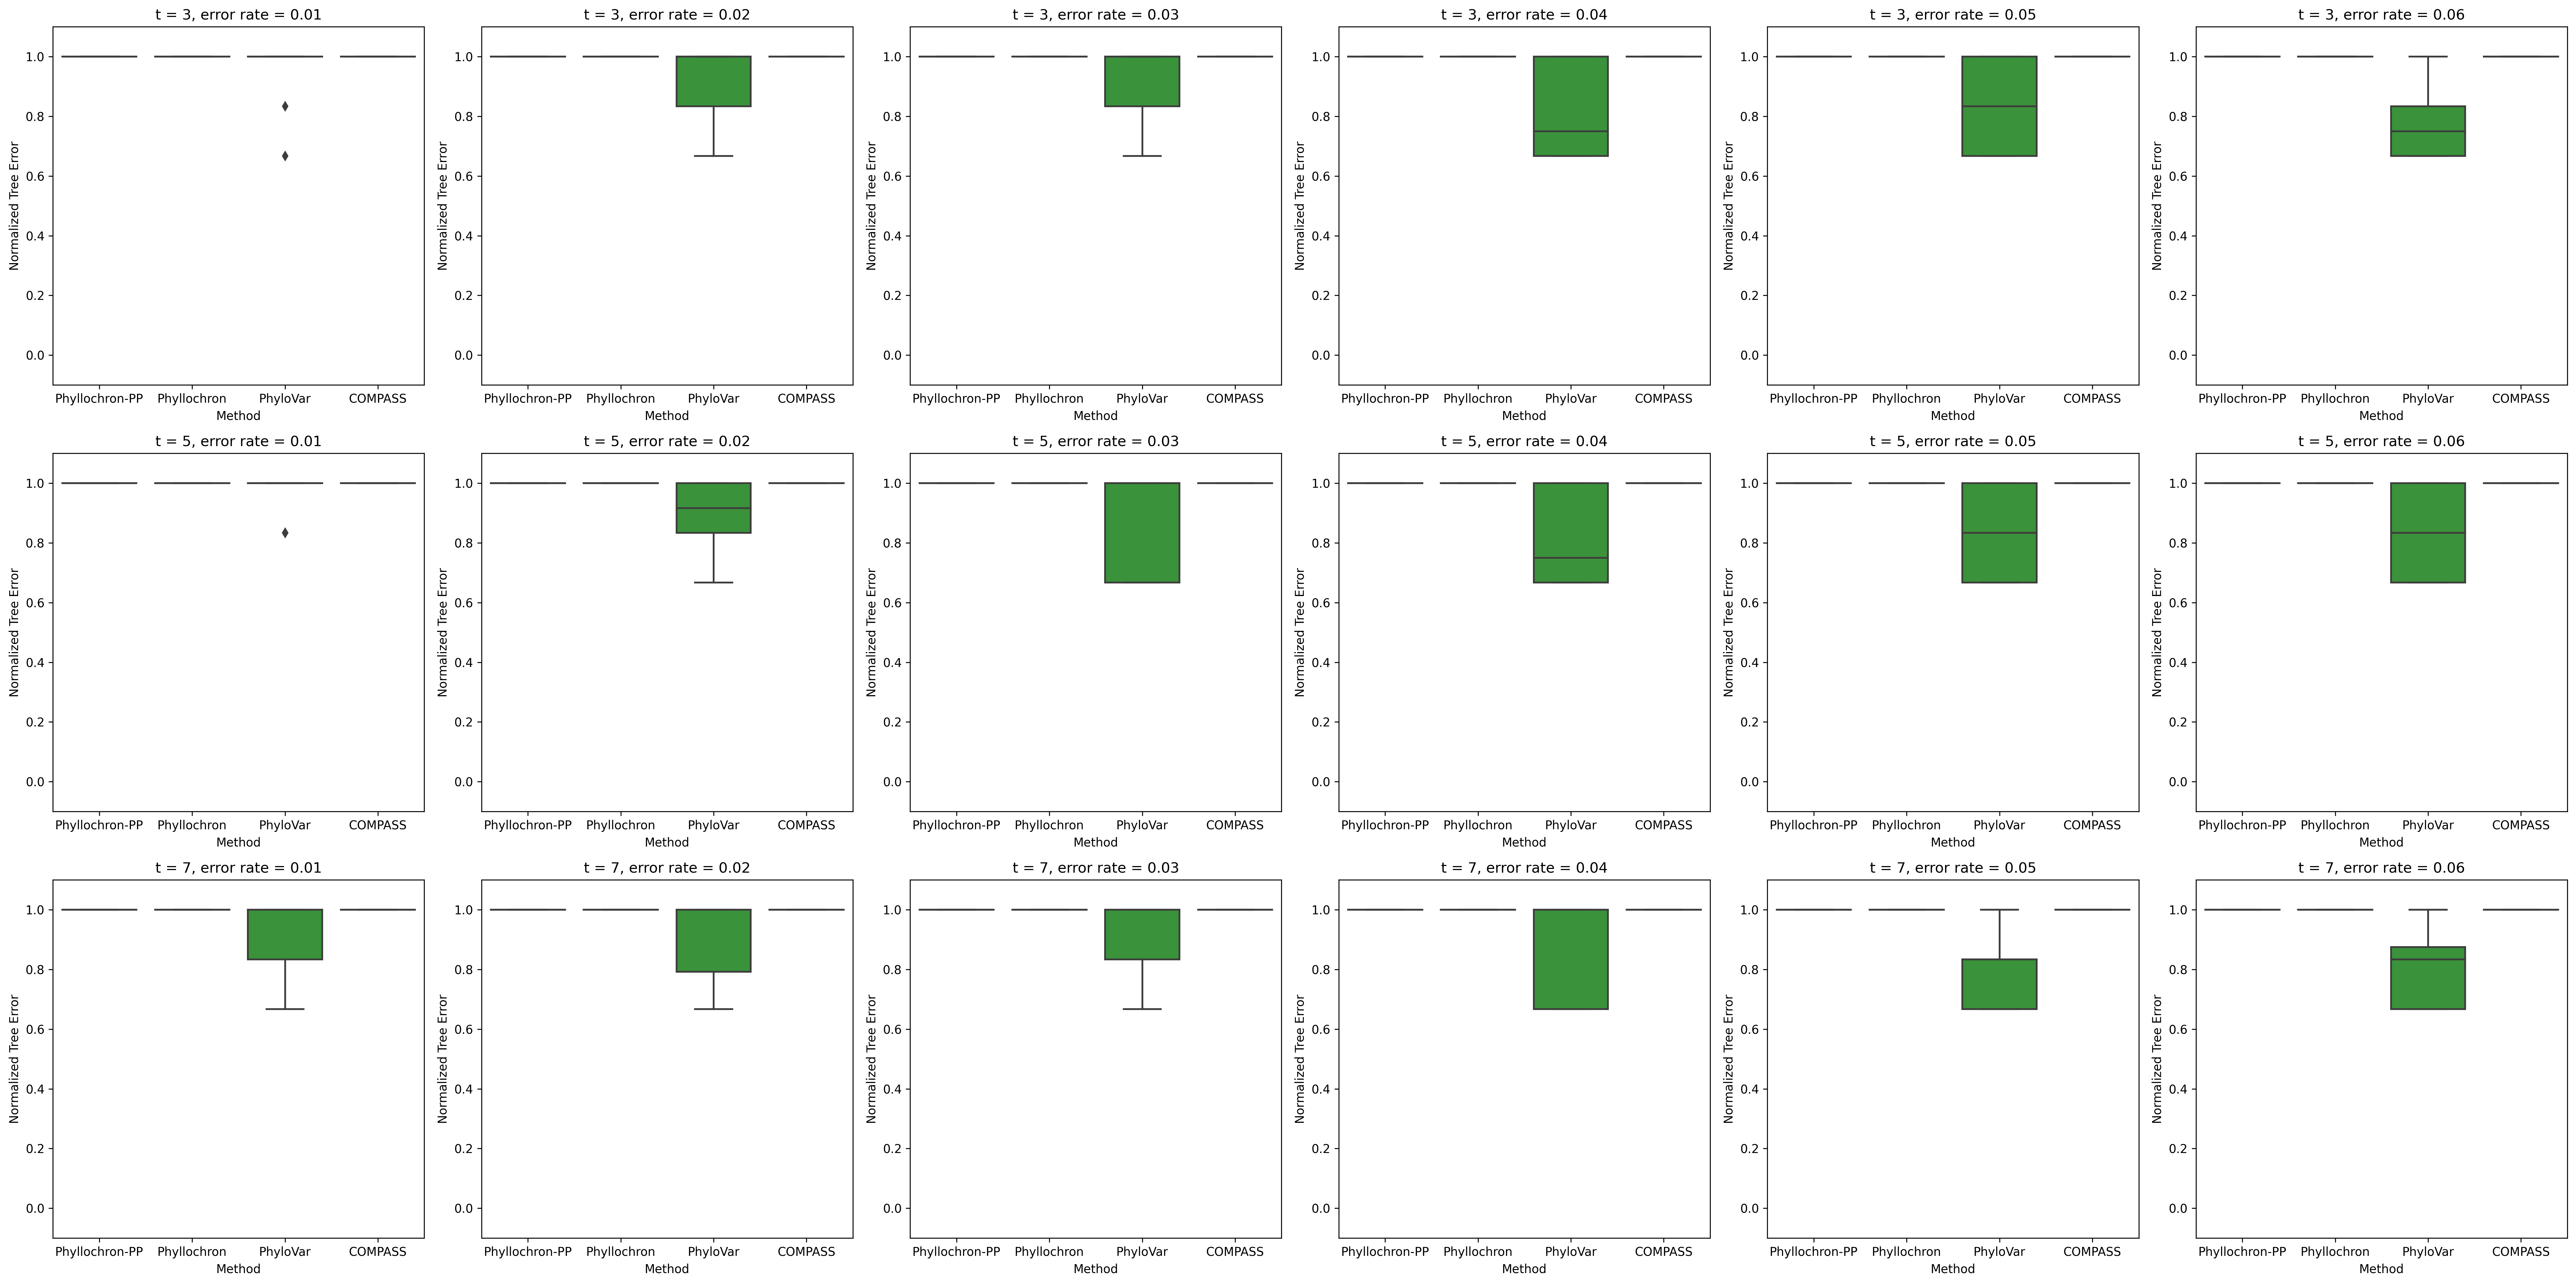

In [268]:
plt.figure()
fig, axs = plt.subplots(len(timepoints), len(error_rates), figsize=(30, 15))
for i, t in enumerate(timepoints):
    for j, prop in enumerate(error_rates):
        phyllochron_pp_diffs = []
        phyllochron_diffs = []
        Phylovar_diffs = []
        COMPASS_diffs = []
        for sd in range(num_replicates + 1):
            if sd < num_replicates:
                og_character_matrix = pd.read_csv(f'../simulations/ground_truth_rc/gt_readcount_{t}_{prop}_{sd}.csv').values[:, 1:]
                phyllochron_df = pd.read_csv(f'../simulations/Phyllochron_RC/phyllochron_{t}_{prop}_{sd}_B.csv')
                phyllochron_pp_df = pd.read_csv(f'../simulations/Phyllochron_PP_RC/phyllochron_pp_{t}_{prop}_{sd}_B.csv')
                Phylovar_df = pd.read_csv(f'../simulations/PhyloVar/phylovar_{t}_{prop}_{sd}/snv.vcf.mat', header=None, sep='\t')
                COMPASS_cell_assignment = pd.read_csv(f'../simulations/COMPASS/compass_{t}_{prop}_{sd}_cellAssignments.tsv', sep='\t')
                COMPASS_genotypes = pd.read_csv(f'../simulations/COMPASS/compass_{t}_{prop}_{sd}_nodes_genotypes.tsv', sep='\t')
    
                
                phyllochron_character_matrix = phyllochron_df.values[:, 1:]
                phyllochron_pp_character_matrix = phyllochron_pp_df.values[:, 1:]
                Phylovar_character_matrix = Phylovar_df.values
                COMPASS_character_matrix = build_compass_matrix(COMPASS_cell_assignment, COMPASS_genotypes)
                

            
                phyllochron_pp_diffs.append(return_score(sort_rows_by_binary_encoding(np.unique(og_character_matrix.astype(int),axis=0)), sort_rows_by_binary_encoding(np.unique(phyllochron_pp_character_matrix, axis=0)))/((nmutations + 1)))
                phyllochron_diffs.append(return_score(sort_rows_by_binary_encoding(np.unique(og_character_matrix.astype(int),axis=0)), sort_rows_by_binary_encoding(np.unique(phyllochron_character_matrix, axis=0)))/((nmutations + 1)))
                Phylovar_diffs.append(return_score(sort_rows_by_binary_encoding(np.unique(og_character_matrix.astype(int),axis=0)),  sort_rows_by_binary_encoding(np.unique(Phylovar_character_matrix.astype(int),axis=0)))/((nmutations + 1)))
                COMPASS_diffs.append(return_score(sort_rows_by_binary_encoding(np.unique(og_character_matrix.astype(int),axis=0)), sort_rows_by_binary_encoding(np.unique(COMPASS_character_matrix.astype(int), axis=0)))/((nmutations + 1) ))

            idx += 1

        data = pd.DataFrame({'Method': num_replicates*['Phyllochron-PP'] + num_replicates*['Phyllochron'] + num_replicates*['PhyloVar'] + num_replicates*['COMPASS'],'Normalized Tree Error':phyllochron_pp_diffs + phyllochron_diffs + Phylovar_diffs + COMPASS_diffs})

        axs[i,j].set_ylim(-0.100, 1.1)

        sns.boxplot(x='Method', y='Normalized Tree Error', data=data, ax = axs[i,j])
        axs[i,j].set_title(f't = {t}, error rate = {prop}')
fig.tight_layout()
plt.show()